In [1]:
# Copyright (c) 2025, ETH Zurich

In [ ]:
%matplotlib inline

In [10]:
import numpy as np
import scipy.constants as cnst
import xraydb
import matplotlib.pyplot as plt
import utils.icru44data as icru44data
import sys

from scipy import interpolate
import xarray as xr
from scipy.interpolate import griddata
import spekpy as sp # Import SpekPy
import scipy.signal as scis
import scipy.stats as stats
import tqdm
import copy
import skimage
import skimage.draw

from scipy.ndimage import rotate

In [4]:
# matplotlib style
plt.style.use("default")

# set FIGWIDTH to latex's \textwidth
FIGWIDTH = 3
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 5
plt.rcParams["figure.figsize"] = (FIGWIDTH, FIGWIDTH * 2 / 3)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = "True"

# images
plt.rcParams["image.interpolation"] = "bicubic"
plt.rcParams["image.cmap"] = "Greys_r"

# axes
# plt.rcParams["axes.spines.right"] = False
# plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.edgecolor"] = "0.7"
plt.rcParams["axes.linewidth"] = "1"

# legend
plt.rcParams["legend.frameon"] = False

plt.rcParams["lines.markersize"] = 2
# plt.rcParams["lines.markerfacecolor"] = "white"
# Okabe-Ito palette
plt.rcParams["axes.prop_cycle"] = plt.cycler(
    color=[
        "#000000",
        "#E69F00",
        "#56B4E9",
        "#009E73",
        "#F0E442",
        "#0072B2",
        "#D55E00",
        "#CC79A7",
    ],
    marker=["o", "^", "s", "p", "D", "v", "v", "d"],
)

plt.rcParams['axes.grid'] = False

In [5]:
def mu_h2o(eng):
    return xraydb.material_mu('H2O', eng)*100

def get_mu_deltas(compound, energies):
    
    assert compound in list(icru44data.icru44dict.keys()), "Compound not in ICRU 44 List"

    deltas = []
    mus = []
    _, _, density, composition = icru44data.icru44dict[compound]
    
    for eng in energies:
        photonenergy = eng * cnst.e
        wavelength = cnst.h * cnst.c / photonenergy
        
        deltas.append(
            np.sum([
                    weight * xraydb.xray_delta_beta(element, density, eng)[0]
                    for (element, weight)
                    in composition
            ])    
        )
        
        mus.append(
            np.sum([
                    weight * density * xraydb.mu_chantler(element, eng) * 100
                    for (element, weight)
                    in composition
            ]) 
        )
        
    deltas = np.asarray(deltas)
    mus = np.asarray(mus)
    
    return mus, deltas


def calculate_opening_angle(l, sample_size):
    op_angle = np.arcsin((sample_size /2) / l)
    return 2*op_angle

def mu_au(eng):
    return xraydb.material_mu('Au', eng)*100

def mu_si(eng):
    return xraydb.material_mu('Si', eng)*100


def mu_pmma(eng):
    return xraydb.material_mu('PMMA', eng)*100

def mu_c(eng):
    return xraydb.material_mu('C', eng, 2.26)*100


def projection_absorption(x, y, r):
    projection = np.zeros_like(x)

    valid_indices = np.where(r**2 - x**2 > 0)
    projection[valid_indices] = 2 * np.sqrt(r**2 - x[valid_indices]**2)
    projection = [projection for i in range(y.shape[0])]
    projection = np.asarray(projection)
    return projection


def mass_breast(radius, density):
    volume = 4/3 * np.pi * radius**3
    mass = volume*density
    return mass, volume

def mass_breast_slice(radius, density, thickness):
    volume = radius**2 * np.pi * thickness
    mass = volume * density
    return mass, volume

def mass_circle_segment(radius, density, thickness, sample_start, op_angle):
    volume = (np.pi*(sample_start + 2*radius)**2 - np.pi*sample_start**2) * op_angle * thickness
    print(op_angle)
    mass = volume * density
    return mass, volume

In [6]:
tube_voltages = np.arange(40, 71, 1)
mu_breasts = {}
mu_gold = {}
mu_silicon = {}
mu_water = {}
for kVp in tube_voltages:
    energies = np.arange(15, kVp+0.5, 0.5)*1e3
    mu_breast_tissue, _ = get_mu_deltas('Breast Tissue (ICRU-44)', energies)
    mu_breasts[kVp] = mu_breast_tissue
    mu_water[kVp] = mu_h2o(energies)
    mu_gold[kVp] = mu_au(energies)
    mu_silicon[kVp] = mu_si(energies)
_, _, density_breast, composition = icru44data.icru44dict['Breast Tissue (ICRU-44)']


## Dose calculation functions

### Rotation approach

In [7]:

def rotate_array_steps_dose(arr, steps):
    rotated_arrays = []
    angle_step = 360 / steps  # Calculate the angle for each step
    
    for i in range(steps):
        angle = i * angle_step  # Current rotation angle
        rotated = rotate(arr, angle, reshape=False, order=1)  # Rotate without reshaping, linear interpolation
        rotated_arrays.append(rotated)
    
    rotated_arrays = np.asarray(rotated_arrays)

    dose_array = np.sum(rotated_arrays, axis = 0)
    return dose_array

    
def calculate_dose_and_intensity_rotation_spectrum(pxSize, L, S, z_G0, breast_size, tube_kVp, expTime, current, vertical_thickness = 0.001, gratings = True, height = None, system = 'Static', verbose = False):

    
    nr_projections = 36
    expTime = expTime / nr_projections

    total_length = S + z_G0
    magnifcation = (L + z_G0 + 0.1) / total_length

    vertical_thickness_area = vertical_thickness / (L + z_G0) * z_G0 * 1e2


    pxSize_phantom = 0.0002 #breast_size / 500

    x = np.arange(-breast_size/2-1*pxSize_phantom, breast_size/2+1*pxSize_phantom, pxSize_phantom)

    phantom = np.zeros((x.shape[0], x.shape[0]))
    size = x.shape[0]
    phantom[skimage.draw.disk(
            (size / 2, size / 2),
            int(breast_size / (x[1]-x[0]) /2))] = 1

    s = sp.Spek(kvp=tube_kVp, dk = 0.1, th = 10, z = z_G0*1e2, mas = expTime * current)
    s.filter('Al', 3)

    op_angle = calculate_opening_angle(L + z_G0 + 0.1, breast_size)
    detector_size = np.tan(op_angle) * total_length # Coverage in the horizontal direction

    eng_step_size = 0.5
    k, f = s.get_spectrum(edges=True, diff = True, flu = True) # Get the spectrum
    tube_spectrum_txt = interpolate.interp1d(k*1e3, f, fill_value = 'extrapolate')
    energies = np.arange(15, tube_kVp+eng_step_size, eng_step_size)*1e3
    spectrum = tube_spectrum_txt(energies)
    
        
    if gratings:
        if system == 'Static':
            att_grating = (np.exp(-mu_au(energies)*height) + np.exp(-mu_pmma(energies) * height))/2 * np.exp(-mu_c(energies) * 300e-6)
        elif system == 'V2':
            att_grating = (np.exp(-mu_au(energies)*height) + np.exp(-mu_si(energies) * height))/2 * np.exp(-mu_si(energies) * 200e-6)
    else: 
        att_grating = 1
    #print(att_grating)
    #print(z_G0 * 1e2 * np.tan(op_angle))
    spectrum_by_opening_angle = spectrum * att_grating *  2 * z_G0 * 1e2 * np.tan(op_angle/2) * vertical_thickness_area  / x.shape[0]
    #plt.plot(spectrum)
    dose_engs = []
    #print('Phantom shape: ', phantom.shape)
    
    for i, eng in enumerate(energies):
        cumsum_phantom_neg = np.cumsum(phantom, axis = 1) * phantom
        negative_term = np.exp(-cumsum_phantom_neg * mu_breasts[tube_kVp][i] * pxSize_phantom)

        cumsum_phantom_pos = (np.cumsum(phantom, axis = 1) - 1) * phantom
        positive_term = np.exp(-cumsum_phantom_pos * mu_breasts[tube_kVp][i] * pxSize_phantom)
        dose_engs.append(spectrum_by_opening_angle[i] * (positive_term - negative_term) * eng)
    dose_all_engs = dose_engs

    dose_engs = np.asarray(dose_engs)
    
    mass_voxel = (pxSize_phantom**2 * vertical_thickness * density_breast*1e3)
    dose_engs = np.sum(dose_engs, axis = 0) * eng_step_size  / mass_voxel 

    dose_reco = rotate_array_steps_dose(dose_engs, nr_projections)

    I0_ = np.sum(spectrum * att_grating**2) * pxSize **2 * (z_G0)**2 / (total_length)**2 * eng_step_size * nr_projections
    I1_ = np.sum(spectrum * np.exp(-mu_breasts[tube_kVp]* breast_size) * att_grating**2)* pxSize **2 * (z_G0)**2 / (total_length)**2 * eng_step_size * nr_projections

    m_breast, volume = mass_breast_slice(breast_size /2, density_breast*1e3, vertical_thickness)

    dose_reco = dose_reco * cnst.electron_volt #/ m_breast #* pxSize_phantom
    dose = np.sum(dose_reco[dose_reco>0] * mass_voxel) / m_breast

    
    if verbose:
        return dose, I0_, I1_, dose_reco, dose_engs, m_breast, volume, pxSize_phantom
    
    else:
        return dose, I0_, I1_, dose_reco

In [11]:
pxSize_static = 75 * 1e-4 * 2

# Geometry parameters system
l_static = 0.8180881351464869
s_static = 1.6361762702929736
z_g0_static = 0.1

# From the Optica paper this corresponds to 22mGy
tube_kvp_static = 70
current_static = 10
expTime_static = 5*60

dose_per_kvp_static = []
I0_per_kvp_static = []
I1_per_kvp_static = []


breast_sizes = [0.06, 0.09, 0.12, 0.14, 0.16, 0.18]

dose_per_breast_size_static = []
I0_per_breast_size_static = []
I1_per_breast_size_static = []
dose_reco = []
dose_engs = []

for bs in breast_sizes:
    dose, I0, I1, reco, dose_eng, m_breast, volume, px_phantom = calculate_dose_and_intensity_rotation_spectrum(pxSize_static, l_static, s_static, z_g0_static, bs, tube_kvp_static, expTime_static, current_static, vertical_thickness = 0.001, gratings=True, height = 180e-6, verbose = True)
    dose_per_breast_size_static.append(dose)
    I0_per_breast_size_static.append(I0)
    I1_per_breast_size_static.append(I1)
    dose_reco.append(reco)
    dose_engs.append(dose_eng)

dose_per_breast_size_static_r = np.asarray(dose_per_breast_size_static)
I0_per_breast_size_static_r = np.asarray(I0_per_breast_size_static)
I1_per_breast_size_static_r = np.asarray(I1_per_breast_size_static)

In [12]:
I1_per_breast_size_static_r[1] / 1200 * (200**2/150**2)

777.9317540893616

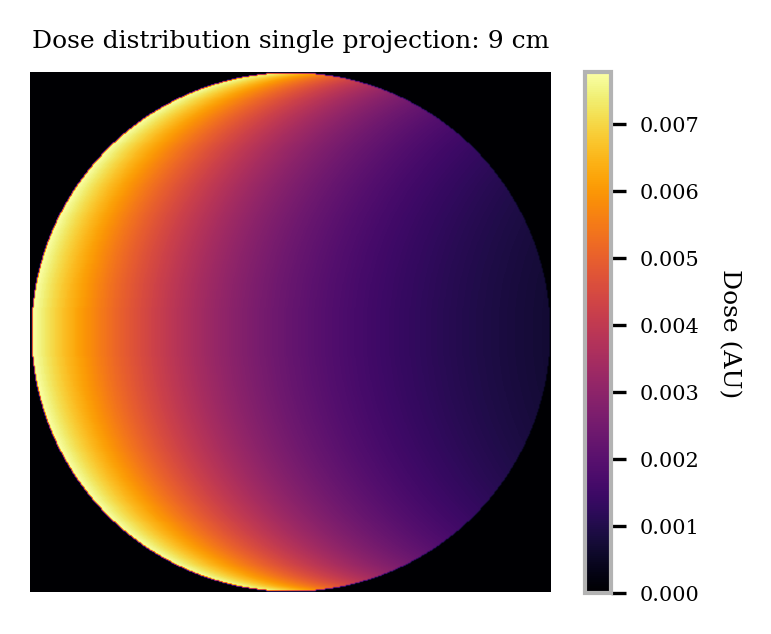

In [13]:
plt.imshow(dose_engs[1] * cnst.electron_volt, cmap = 'inferno')
cbar = plt.colorbar()
cbar.set_label('Dose (AU)', rotation=270, labelpad=10, fontsize=6)
plt.axis('off')
plt.title('Dose distribution single projection: 9 cm')
plt.savefig('Dose_distribution_single_angle.png', bbox_inches = 'tight', transparent = True)


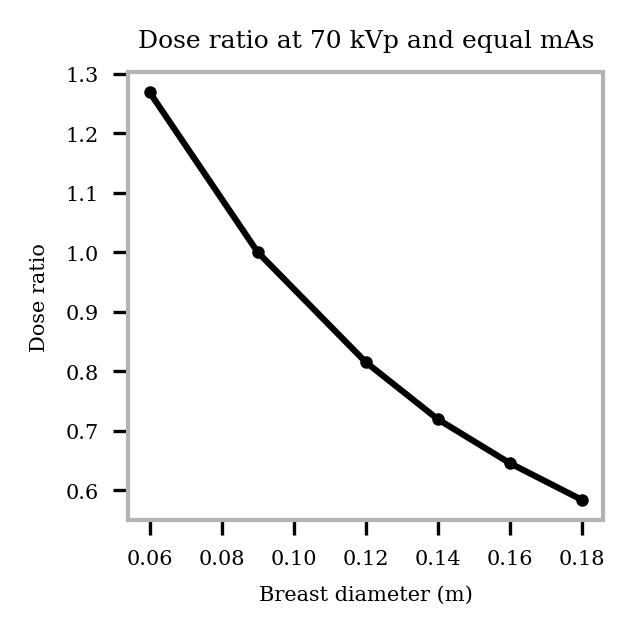

In [14]:
plt.figure(figsize=(2, 2))
plt.plot(breast_sizes, dose_per_breast_size_static_r / dose_per_breast_size_static_r[1])
plt.title('Dose ratio at 70 kVp and equal mAs')
plt.xlabel('Breast diameter (m)')
plt.ylabel('Dose ratio')
plt.savefig('breast_diameter_static_dose.png', bbox_inches = 'tight', transparent = True)

In [15]:
dose_per_breast_size_static_r / dose_per_breast_size_static_r[1]

array([1.26832793, 1.        , 0.81535574, 0.71953778, 0.64574029,
       0.5840956 ])

In [16]:
from matplotlib_scalebar.scalebar import ScaleBar

(-0.5, 301.5, 301.5, -0.5)

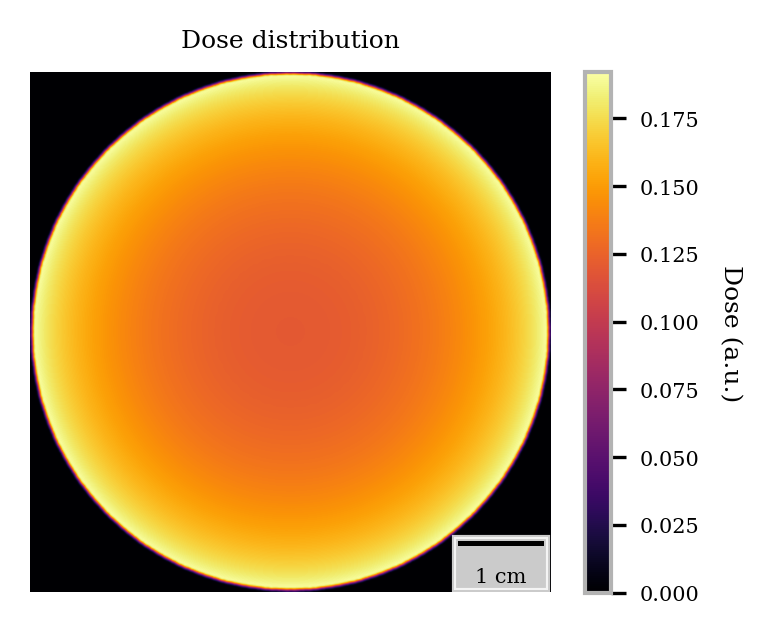

In [17]:
# Create a sample image
fig, ax = plt.subplots()
im = ax.imshow(dose_reco[0], cmap = 'inferno')
cbar = plt.colorbar(im, ax = ax)
cbar.set_label('Dose (a.u.)', rotation=270, labelpad=10, fontsize=6)
# Add a scale bar
scalebar = ScaleBar(0.0002,  # Pixel size in physical units (e.g., 1 unit per pixel)
                    "m",  # Unit of measurement
                    length_fraction=0.2,  # Fraction of the axis the scale bar should cover
                    location="lower right",  # Location of the scale bar
                    scale_loc="bottom",  # Position of the scale label
                    box_alpha=0.8)  # Transparency of the box
ax.add_artist(scalebar)
plt.title('Dose distribution')
ax.axis('off')

Dose is:  0.1460497762848236
Dose is:  0.11596678752427511
Dose is:  0.09492066974142851
Dose is:  0.08434448220770425
Dose is:  0.07573706829356376
Dose is:  0.06854030403973212


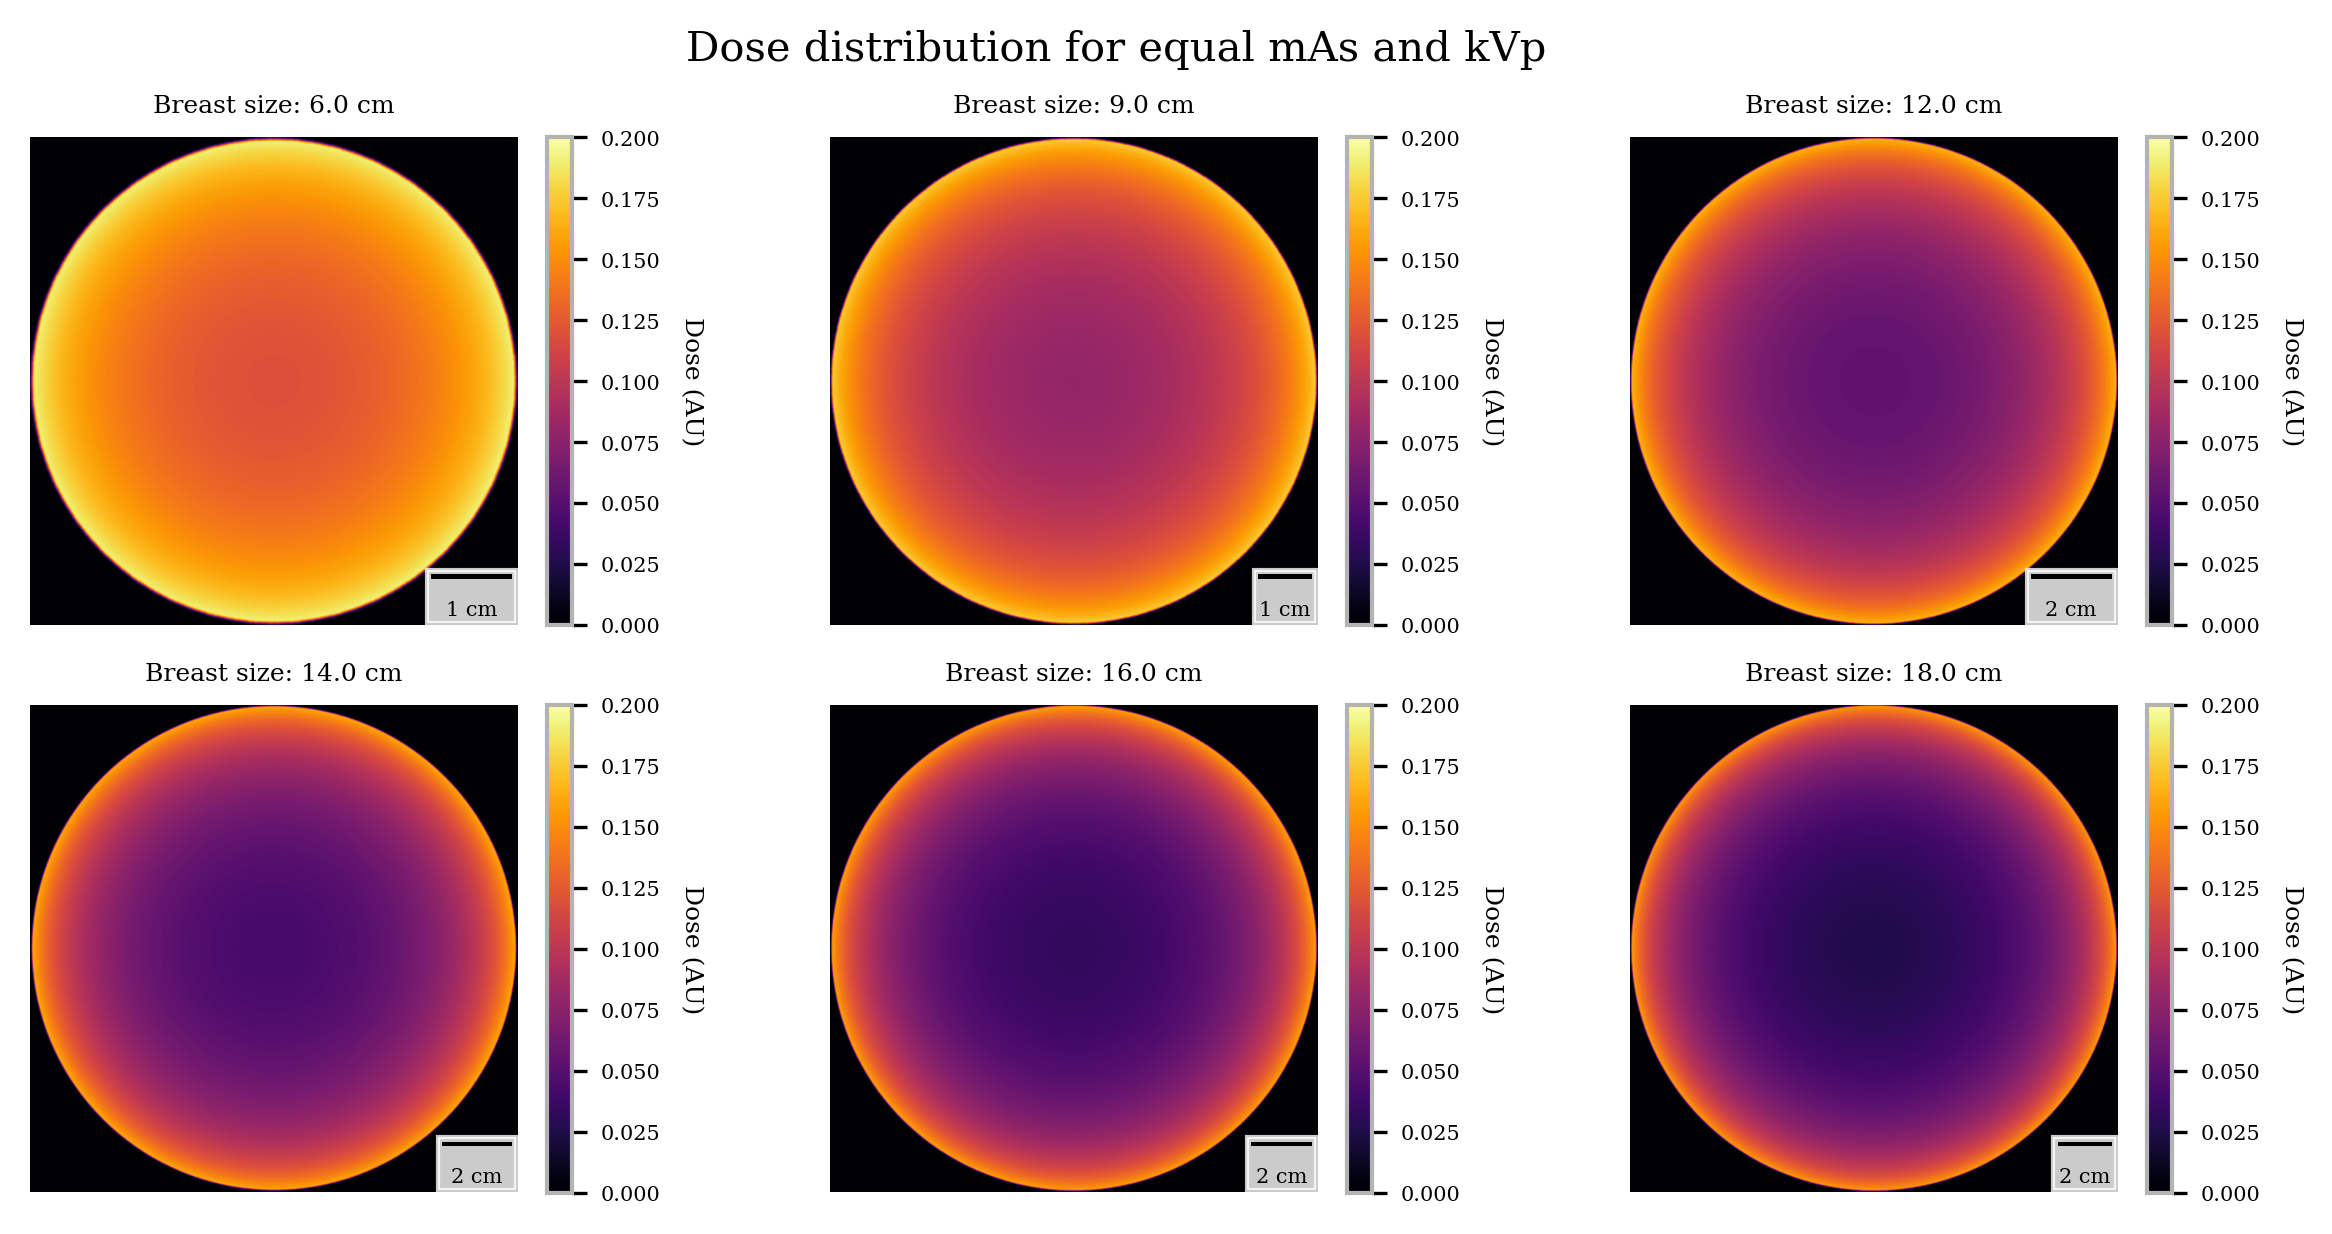

In [18]:
fig, ax = plt.subplots(figsize= (8,4), nrows = 2, ncols = 3)
ax = ax.ravel()
for i, bs in enumerate(breast_sizes):
    im = ax[i].imshow(dose_reco[i], cmap = 'inferno', vmax = 0.2)
    volume_value = np.sum(dose_reco[i][dose_reco[i]>0]) / np.sum(dose_reco[i]>0)
    print('Dose is: ', volume_value)
    cbar = plt.colorbar(im, ax = ax[i], fraction = 0.08)
    cbar.set_label('Dose (AU)', rotation=270, labelpad=10, fontsize=6)
    # Add a scale bar
    scalebar = ScaleBar(0.0002,  # Pixel size in physical units (e.g., 1 unit per pixel)
                        "m",  # Unit of measurement
                        length_fraction=0.2,  # Fraction of the axis the scale bar should cover
                        location="lower right",  # Location of the scale bar
                        scale_loc="bottom",  # Position of the scale label
                        box_alpha=0.8)  # Transparency of the box
    ax[i].add_artist(scalebar)
    ax[i].set_title(f"Breast size: {bs*100:.1f} cm")
    ax[i].axis('off')

fig.suptitle('Dose distribution for equal mAs and kVp', fontsize=10)
plt.savefig('dose_distribution_different_breast_sizes.png', bbox_inches = 'tight', transparent = True)

In [19]:
pxSize_static = 75 * 1e-4 * 2

# Geometry parameters system
l_static = 0.8180881351464869
s_static = 1.6361762702929736
z_g0_static = 0.1

# From the Optica paper this corresponds to 22mGy
tube_kvp_static = 70
current_static = 10
expTime_static = 5*60

dose_per_kvp_static = []
I0_per_kvp_static = []
I1_per_kvp_static = []


breast_sizes = [0.06, 0.09, 0.12, 0.14, 0.16, 0.18]

dose_per_breast_size_static = []
I0_per_breast_size_static = []
I1_per_breast_size_static = []
dose_reco = []

for bs in breast_sizes:
    dose, I0, I1, reco, = calculate_dose_and_intensity_rotation_spectrum(pxSize_static, l_static, s_static, z_g0_static, bs, tube_kvp_static, expTime_static, current_static, vertical_thickness = 0.001, gratings=True, height = 180e-6)
    dose_per_breast_size_static.append(dose)
    I0_per_breast_size_static.append(I0)
    I1_per_breast_size_static.append(I1)
    dose_reco.append(reco)

dose_per_breast_size_static_r = np.asarray(dose_per_breast_size_static)
I0_per_breast_size_static_r = np.asarray(I0_per_breast_size_static)
I1_per_breast_size_static_r = np.asarray(I1_per_breast_size_static)
#dose_sino = np.asarray(dose_sino)

- We keep the current and time the same so that we can match the dose to the change in voltage alone. 
- The rest is linear. 
- We know from Rawlik et al that the dose for 5 minute scan with 10mA and 70kVp corresponds to 22mGy with the gratings

### Rawlik et al.

- Dose for different breast sizes for equal current
- We measure for 6, 9, 12, 15, 18, 21cm
- We know that for 9cm as in the Optica paper this corresponds to 22mGy for 5 Minutes, 10mA and 70kVp

In [20]:
pxSize_static = 75 * 1e-4 * 2

# Geometry parameters system
l_static = 0.8180881351464869
s_static = 1.6361762702929736
z_g0_static = 0.1

# From the Optica paper this corresponds to 22mGy

breast_sizes = [0.06, 0.09, 0.12, 0.14, 0.16, 0.18]

dose_per_breast_size_static = []
I0_per_breast_size_static = []
I1_per_breast_size_static = []

tube_kvp_static = 70
current_static = 10
expTime_static = 5*60

for bs in breast_sizes:
    dose, I0, I1, _ = calculate_dose_and_intensity_rotation_spectrum(pxSize_static, l_static, s_static, z_g0_static, bs, tube_kvp_static, expTime_static, current_static, gratings=True, height = 180e-6)
    dose_per_breast_size_static.append(dose)
    I0_per_breast_size_static.append(I0)
    I1_per_breast_size_static.append(I1)    

dose_per_breast_size_static = np.asarray(dose_per_breast_size_static)
I0_per_breast_size_static = np.asarray(I0_per_breast_size_static)
I1_per_breast_size_static = np.asarray(I1_per_breast_size_static)

Text(0, 0.5, 'Dose ratio')

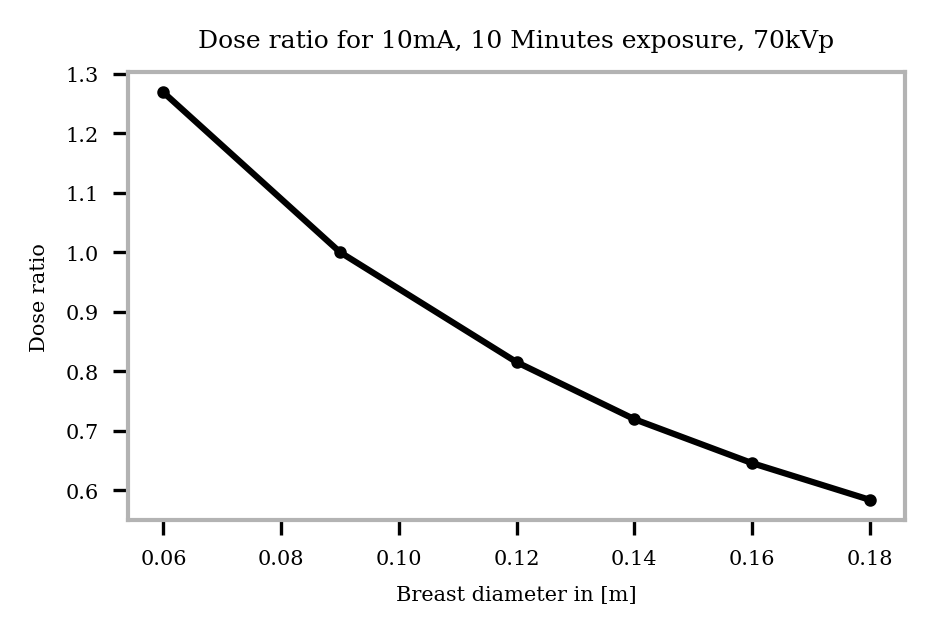

In [21]:
plt.plot(breast_sizes, dose_per_breast_size_static / dose_per_breast_size_static[1])
plt.title('Dose ratio for 10mA, 10 Minutes exposure, 70kVp')
plt.xlabel('Breast diameter in [m]')
plt.ylabel('Dose ratio')

6	1.21
9 	1
12 	0.88
14 	0.82
16 	0.79

Text(0, 0.5, 'Dose ratio')

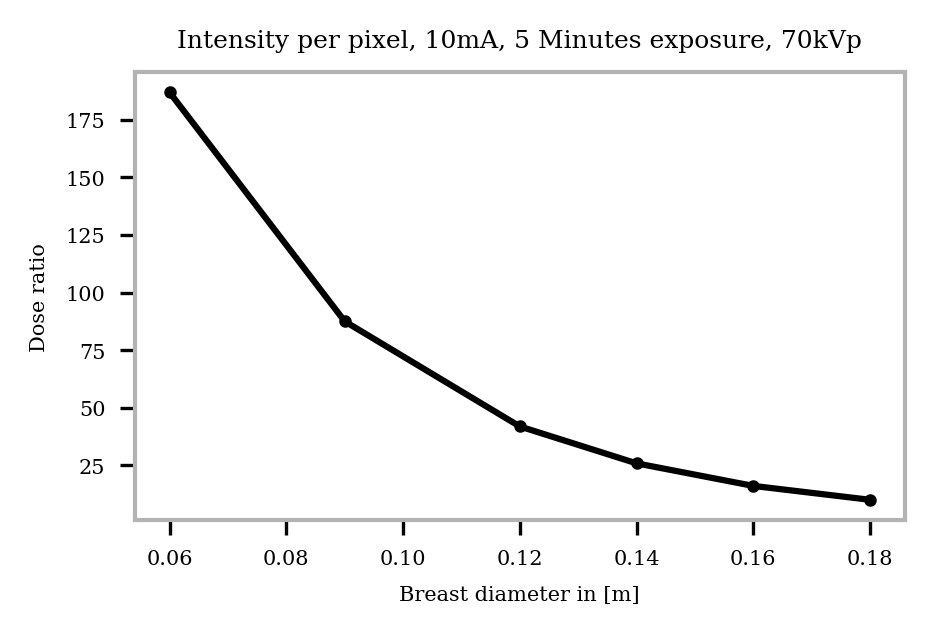

In [22]:
plt.plot(breast_sizes, I1_per_breast_size_static / (1200 * 5))
plt.title('Intensity per pixel, 10mA, 5 Minutes exposure, 70kVp')
plt.xlabel('Breast diameter in [m]')
plt.ylabel('Dose ratio')

Text(0.5, 0.98, 'Rawlik et al, for different breast sizes')

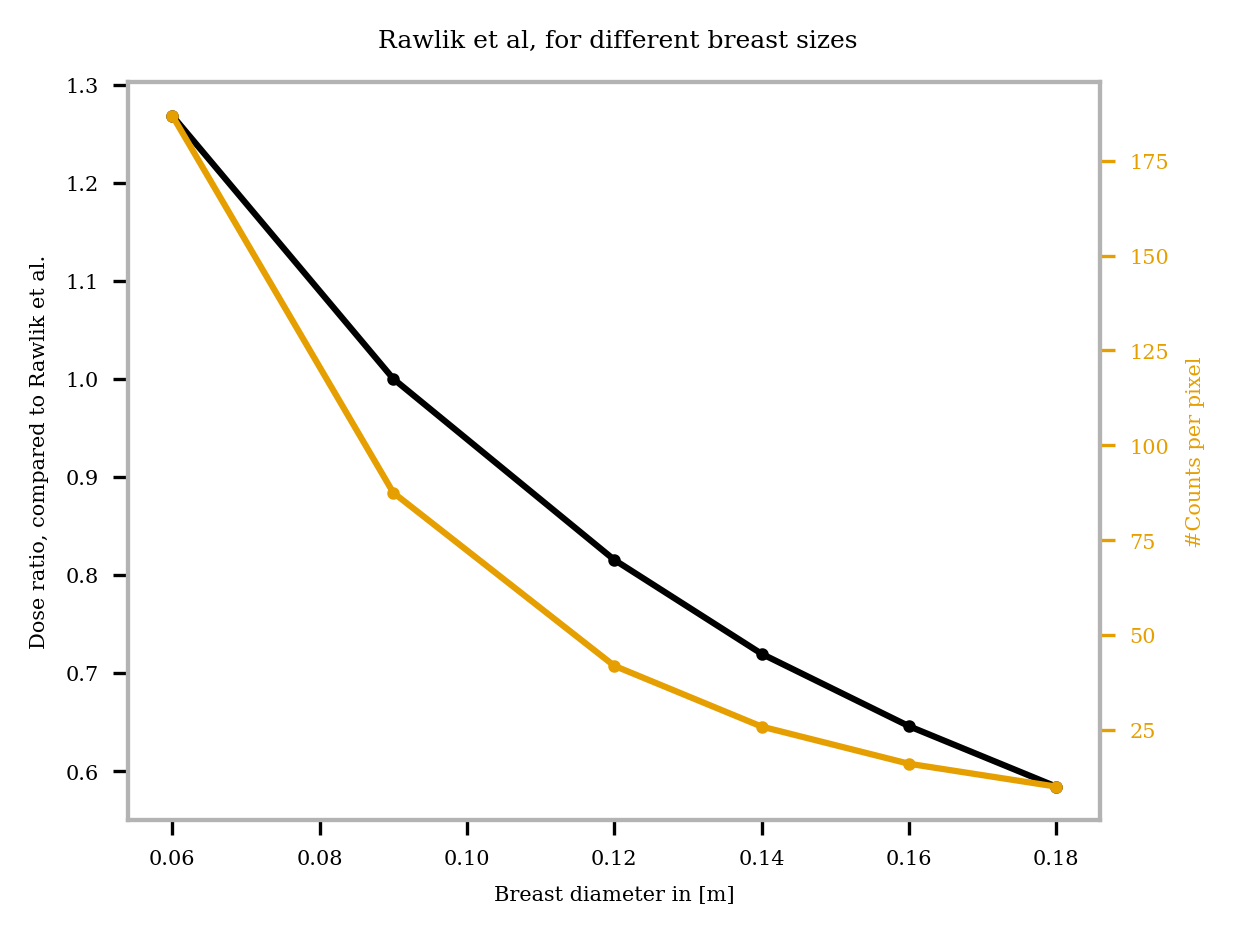

In [23]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(breast_sizes,dose_per_breast_size_static / dose_per_breast_size_static[np.argwhere(np.asarray(breast_sizes) == 0.09)[0][0]])
ax.set_xlabel("Breast diameter in [m]")
ax.set_ylabel("Dose ratio, compared to Rawlik et al.", )
ax.tick_params(axis='y')


# Create a second y-axis sharing the same x-axis
ax2 = ax.twinx()
color2 = "#E69F00"
ax2.plot(breast_sizes, I1_per_breast_size_static / (1200 * 5), color = color2)
ax2.set_ylabel("#Counts per pixel", color = color2)
ax2.tick_params(axis='y', labelcolor = color2, color = color2)

fig.suptitle('Rawlik et al, for different breast sizes')


### GI-BCT V2

In [24]:
pxSize_V2 = 100 * 1e-4 * 2

# Geometry parameters system
l_V2 = 0.6456992289397102
s_V2 = 1.2913984578794204
z_g0_V2 = 0.15

# Tube parameters
# I think this corresponds to approximately 90mGy
tube_kvp_V2 = 70 # in kVp
expTime_V2 = 5*60 # in seconds
current_V2 =  10 # in mA

# breast size parameters
breast_size = 0.14


dose_per_kvp_V2 = []
I0_per_kvp_V2 = []
I1_per_kvp_V2 = []

for kVp in tube_voltages:
    dose, I0, I1, _ = calculate_dose_and_intensity_rotation_spectrum(pxSize_V2, l_V2, s_V2, z_g0_V2, breast_size, kVp, expTime_static, current_static, vertical_thickness = 0.001, gratings=True, height = 180e-6, system = 'V2')
    dose_per_kvp_V2.append(dose)
    I0_per_kvp_V2.append(I0)
    I1_per_kvp_V2.append(I1)    

dose_per_kvp_V2 = np.asarray(dose_per_kvp_V2)
I0_per_kvp_V2 = np.asarray(I0_per_kvp_V2)
I1_per_kvp_V2 = np.asarray(I1_per_kvp_V2)

Text(0.5, 0.98, 'GI-BCT V2 for different kVp')

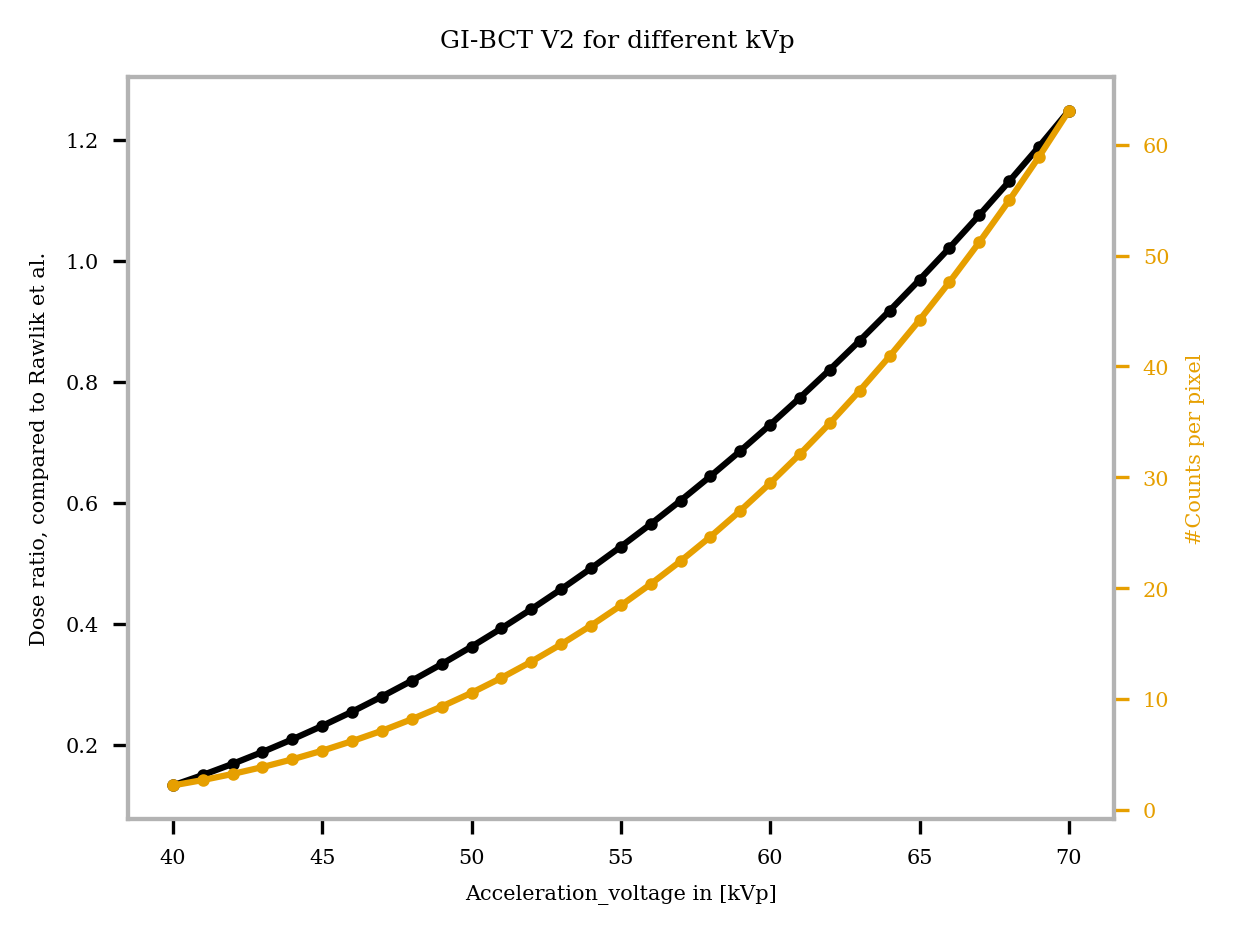

In [25]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(tube_voltages, dose_per_kvp_V2 / dose_per_breast_size_static[np.argwhere(np.asarray(breast_sizes) == breast_size)[0][0]])
ax.set_xlabel("Acceleration_voltage in [kVp]")
ax.set_ylabel("Dose ratio, compared to Rawlik et al.", )
ax.tick_params(axis='y')


# Create a second y-axis sharing the same x-axis
ax2 = ax.twinx()
color2 = "#E69F00"
ax2.plot(tube_voltages, I1_per_kvp_V2 / (1200 * 5), color = color2)
ax2.set_ylabel("#Counts per pixel", color = color2)
ax2.tick_params(axis='y', labelcolor = color2, color = color2)

fig.suptitle('GI-BCT V2 for different kVp')

In [26]:
pxSize_V2 = 100 * 1e-4 * 2

# Geometry parameters system
l_V2 = 0.6456992289397102
s_V2 = 1.2913984578794204
z_g0_V2 = 0.15

# Tube parameters
# I think this corresponds to approximately 90mGy
tube_kvp_V2 = 70 # in kVp
expTime_V2 = 5*60 # in seconds
current_V2 =  10 # in mA

# breast size parameters
breast_sizes = [0.06, 0.09, 0.12, 0.14, 0.16, 0.18]

dose_V2 = {}
I0_V2 = {}
I1_V2 = {}

for bs in breast_sizes:
    dose_per_kvp = []
    I0_per_kvp = []
    I1_per_kvp = []
    for kVp in tube_voltages:
        dose, I0, I1, _ = calculate_dose_and_intensity_rotation_spectrum(pxSize_V2, l_V2, s_V2, z_g0_V2, bs, kVp, expTime_static, current_static, vertical_thickness = 0.001, gratings=True, height = 180e-6, system = 'V2')
        dose_per_kvp.append(dose)
        I0_per_kvp.append(I0)
        I1_per_kvp.append(I1)    
    
    dose_per_kvp = np.asarray(dose_per_kvp)
    I0_per_kvp = np.asarray(I0_per_kvp)
    I1_per_kvp = np.asarray(I1_per_kvp)

    dose_V2[bs] = dose_per_kvp
    I0_V2[bs] = I0_per_kvp
    I1_V2[bs] = I1_per_kvp


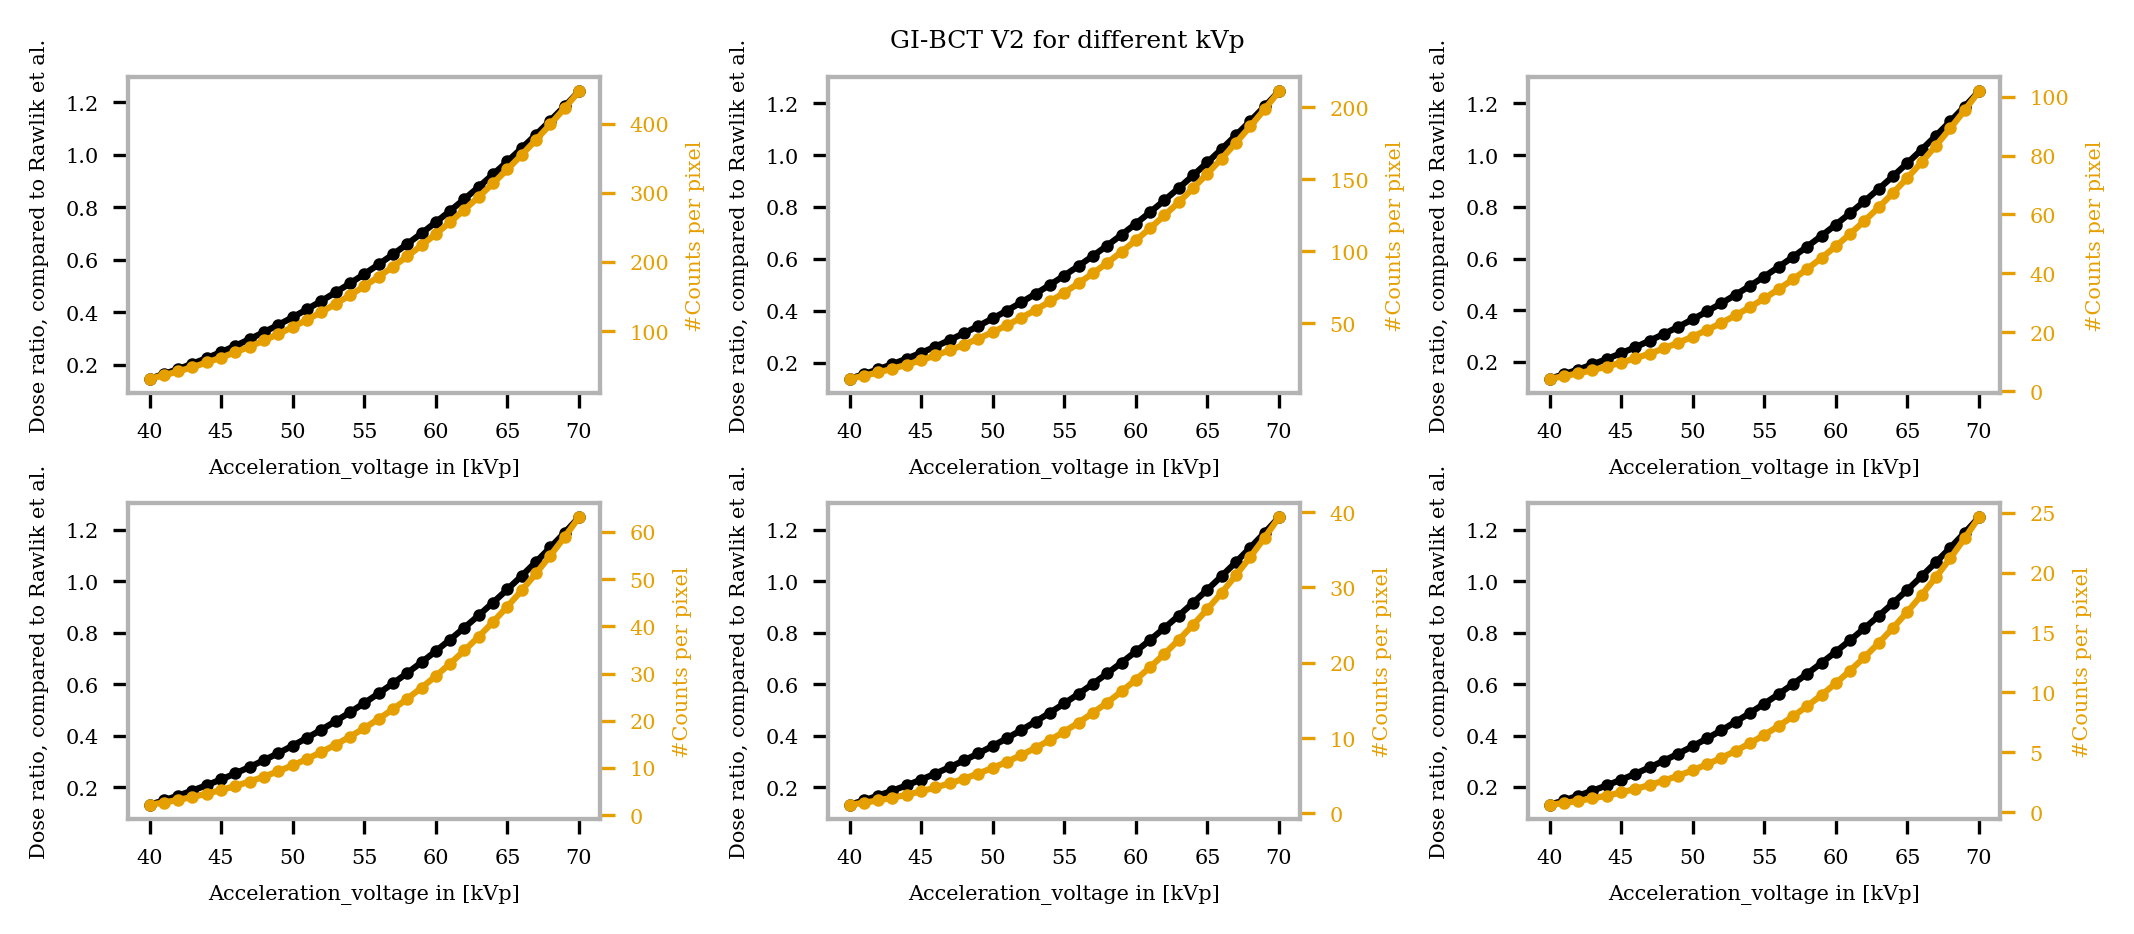

In [27]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(7,3))

ax = ax.ravel()
for i, bs in enumerate(breast_sizes):
    ax[i].plot(tube_voltages, dose_V2[bs] / dose_per_breast_size_static[i])
    ax[i].set_xlabel("Acceleration_voltage in [kVp]")
    ax[i].set_ylabel("Dose ratio, compared to Rawlik et al.", )
    ax[i].tick_params(axis='y')


    # Create a second y-axis sharing the same x-axis
    ax2 = ax[i].twinx()
    color2 = "#E69F00"
    ax2.plot(tube_voltages, I1_V2[bs] / (1200 * 5), color = color2)
    ax2.set_ylabel("#Counts per pixel", color = color2)
    ax2.tick_params(axis='y', labelcolor = color2, color = color2)

    fig.suptitle('GI-BCT V2 for different kVp')

## Dose of 10mGy

- We want now to match all doses for all breast sizes to 10mGy and compare the number of counts we have for a single detector pixel
- We first match on the static setup the mAs such, that we move from 22mGy to 10mGy. So we need to reduce the mAs by a factor of 22/10 = 2.2
- Then we divide the inital counts by the dose ratio. So smaller breast sizes should get less counts

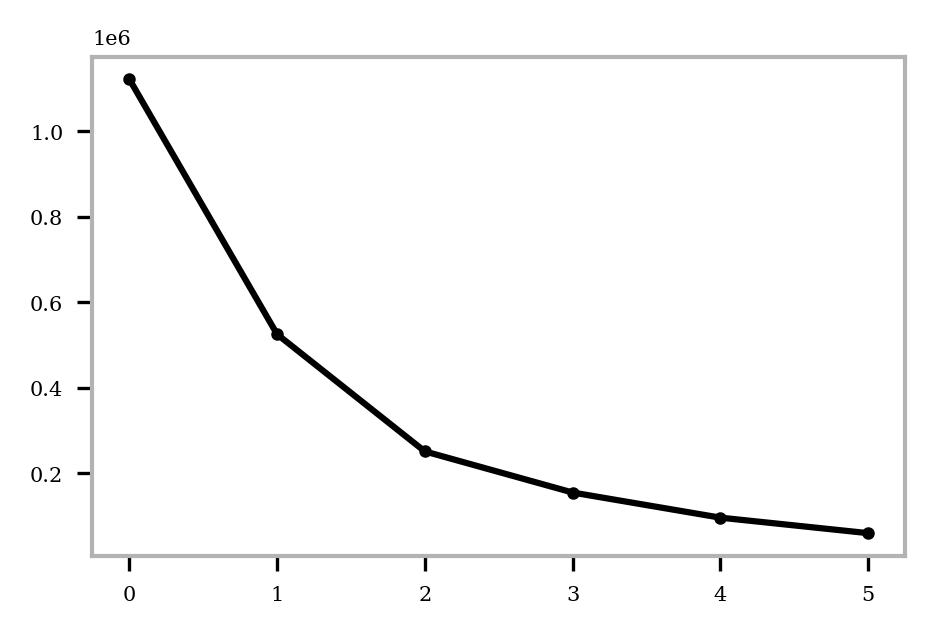

In [28]:
plt.plot(I1_per_breast_size_static)

Text(0, 0.5, '#Counts per pixel for 5 phase steps with 1200 projections')

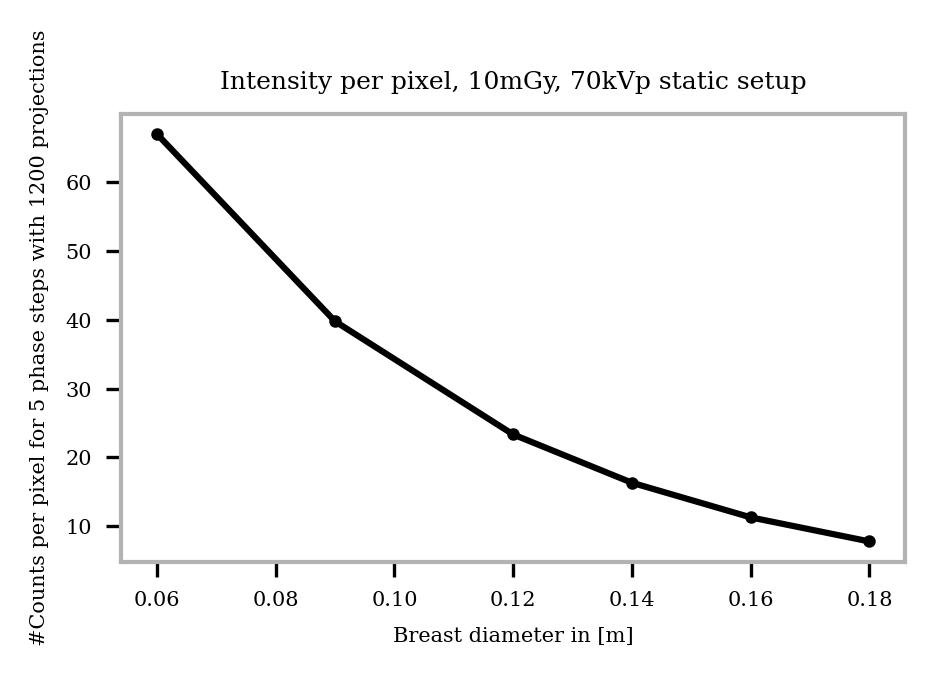

In [29]:
nr_projections = 1200
phase_steps = 5
dose_ratio_static = dose_per_breast_size_static / dose_per_breast_size_static[1]
plt.plot(breast_sizes, I1_per_breast_size_static / (nr_projections * phase_steps) / (22 / 10) / dose_ratio_static)
plt.title('Intensity per pixel, 10mGy, 70kVp static setup')
plt.xlabel('Breast diameter in [m]')
plt.ylabel('#Counts per pixel for 5 phase steps with 1200 projections')

In [30]:
I1_per_breast_size_static

array([1121525.08338023,  525103.93401032,  251238.51726569,
        155108.43816345,   96335.64359738,   60140.61450653])

Text(0.5, 1.0, 'Dose ratio for different breast sizes')

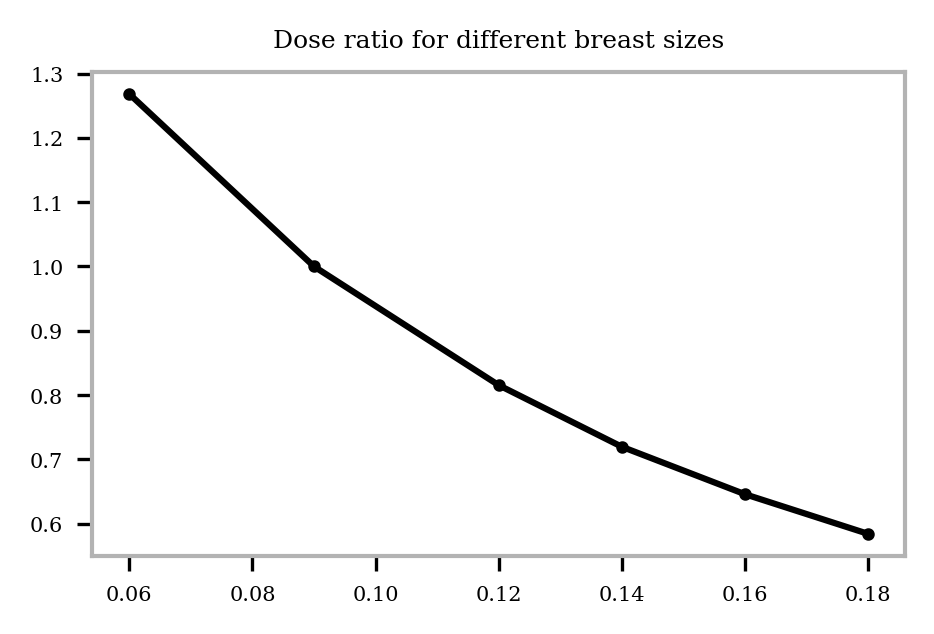

In [31]:
plt.plot(breast_sizes, dose_per_breast_size_static / dose_per_breast_size_static[1])
plt.title('Dose ratio for different breast sizes')

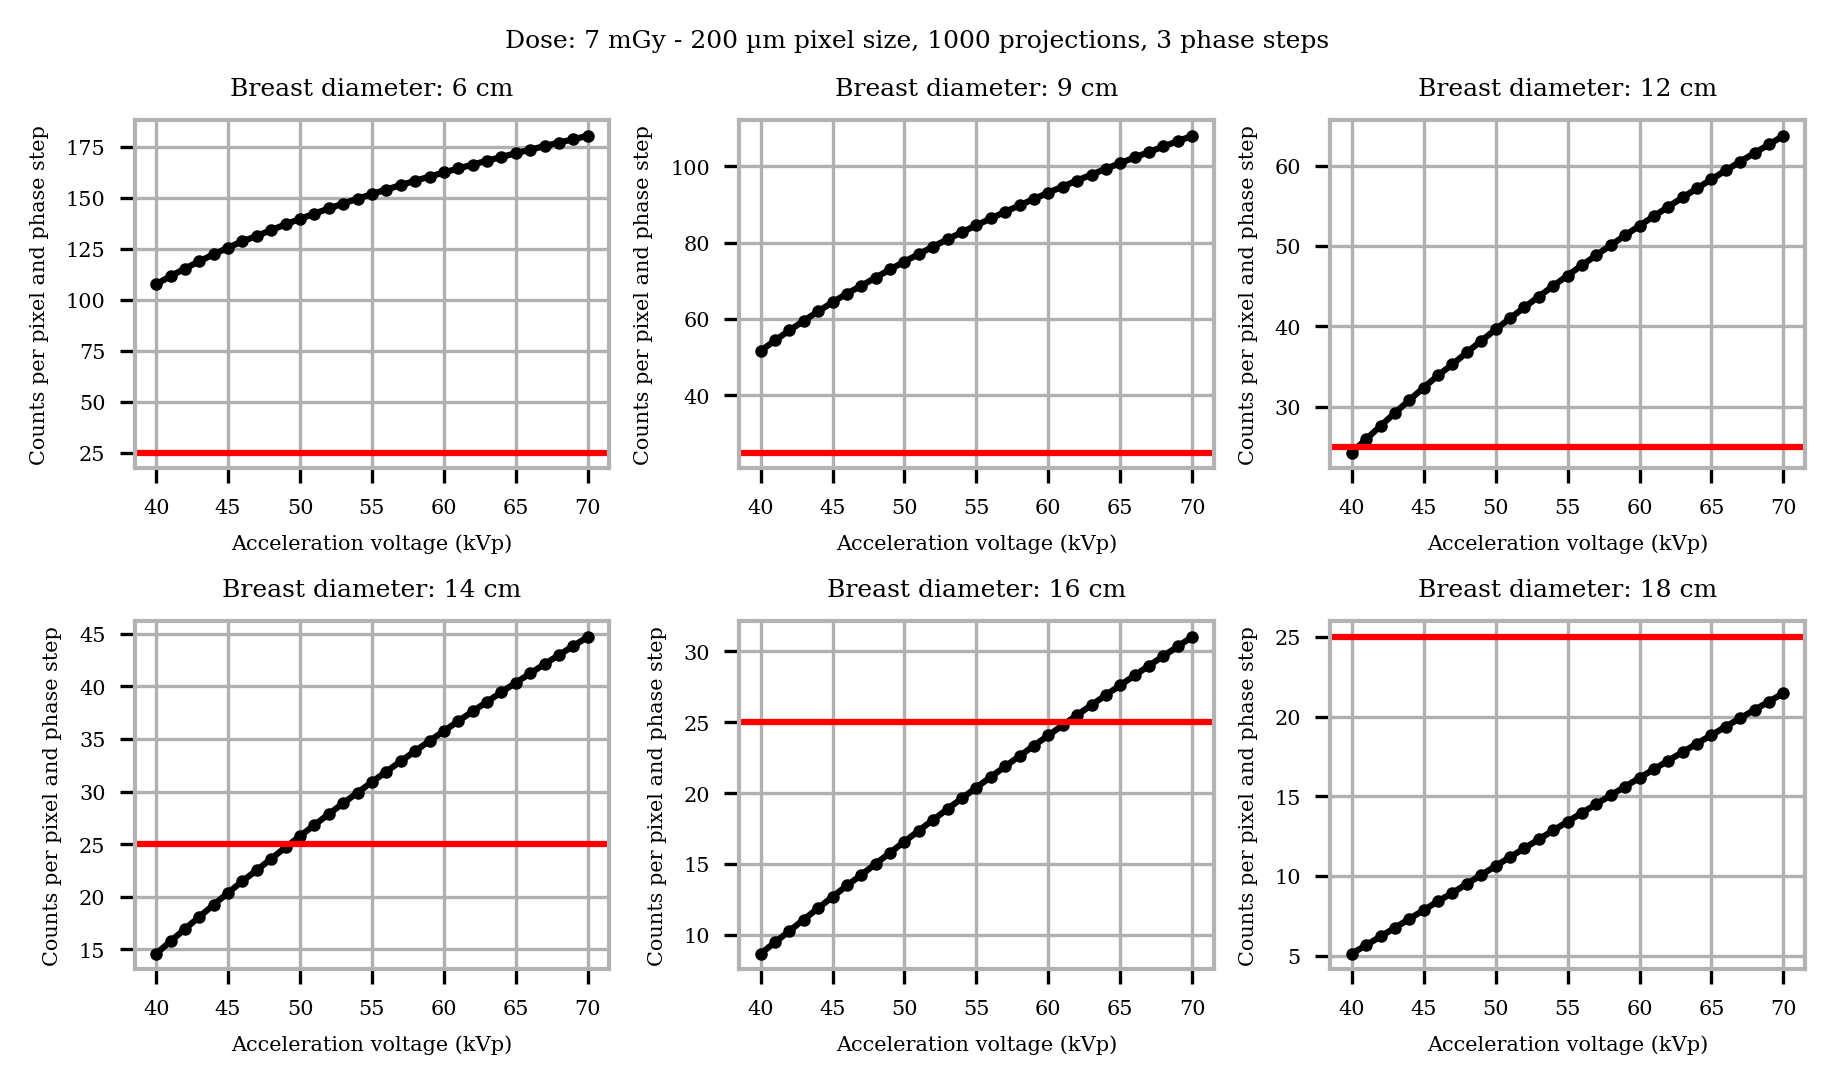

In [32]:
# Calculate counts per pixel for different breast sizes for a dose of 10mGy
nr_projections = 1000
phase_steps = 3
dose = 7

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(6,3.5))
ax = ax.ravel()
for i, bs in enumerate(breast_sizes):

    dose_size_ratio = dose_per_breast_size_static[i] / dose_per_breast_size_static[1]
    dose_ratio_per_kvp = dose_V2[bs] / dose_per_breast_size_static[i]
    ax[i].plot(tube_voltages, I1_V2[bs] / (nr_projections * phase_steps) / (22 / dose) / dose_ratio_per_kvp / dose_size_ratio)
    ax[i].set_xlabel("Acceleration voltage (kVp)")
    ax[i].set_ylabel("Counts per pixel and phase step", )
    ax[i].tick_params(axis='y')
    ax[i].set_title(f"Breast diameter: {(bs*100):.0f} cm")
    ax[i].grid('on')
    ax[i].axhline(25, color = 'red')
fig.suptitle(f"Dose: {dose} mGy - 200 µm pixel size, 1000 projections, 3 phase steps")
plt.savefig('counts_for_7mGy.png', bbox_inches = 'tight', transparent = True)

In [33]:
I1_per_breast_size_static_r[1] / 1000 / 3 * 7 / 22 * (150**2 / 200**2)

31.3272233358429

In [34]:
I1_per_breast_size_static[1] * 7 / 22 / 1000 / 3 * (200**2 / 150**2)

99.00949597500967

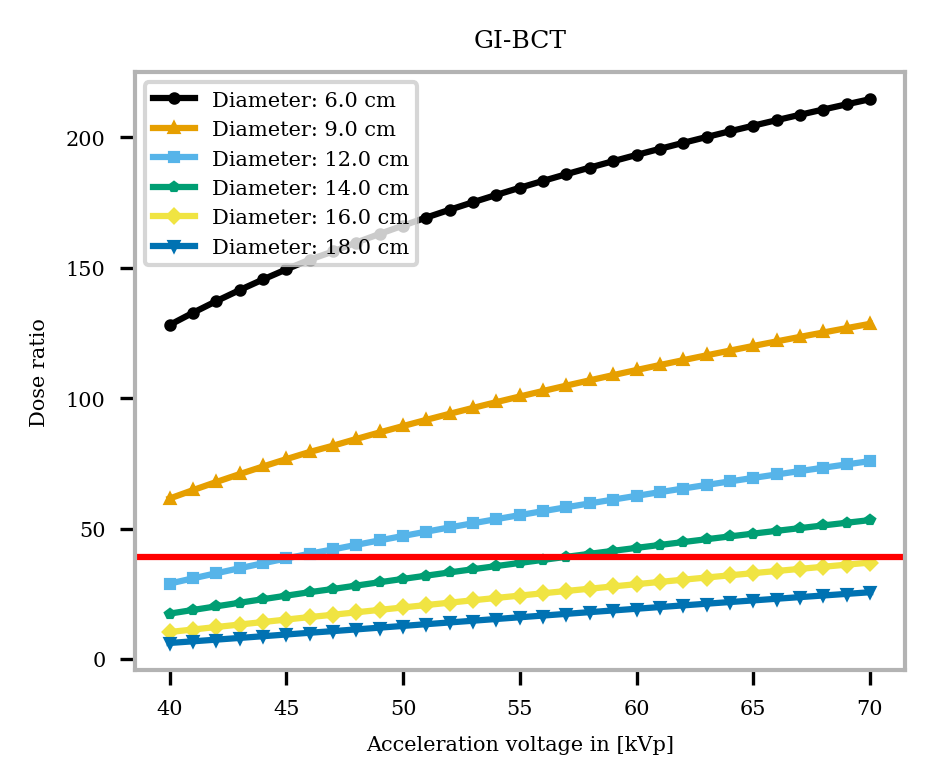

In [35]:
plt.rcParams["legend.frameon"] = True
# Calculate counts per pixel for different breast sizes for a dose of 10mGy
nr_projections = 1200
phase_steps = 3
dose = 10
plt.figure(figsize=(3,2.5))

for i, bs in enumerate(breast_sizes):

    dose_size_ratio = dose_per_breast_size_static[i] / dose_per_breast_size_static[1]
    dose_ratio_per_kvp = dose_V2[bs] / dose_per_breast_size_static[i]
    plt.plot(tube_voltages,  I1_V2[bs] / (nr_projections * phase_steps) / (22 / dose) / dose_ratio_per_kvp / dose_size_ratio, label = f"Diameter: {bs*1e2:.1f} cm")
plt.xlabel("Acceleration voltage in [kVp]")
plt.ylabel("Dose ratio" )
plt.tick_params(axis='y')
plt.legend()
plt.axhline(38.9, color = 'red')
#plt.grid('on')
plt.title('GI-BCT')
plt.rcParams["legend.frameon"] = False
#plt.savefig('counts_per_pixel.png', bbox_inches = 'tight', transparent = True)

## 

# Dose ratios to Rawlik for equal charge

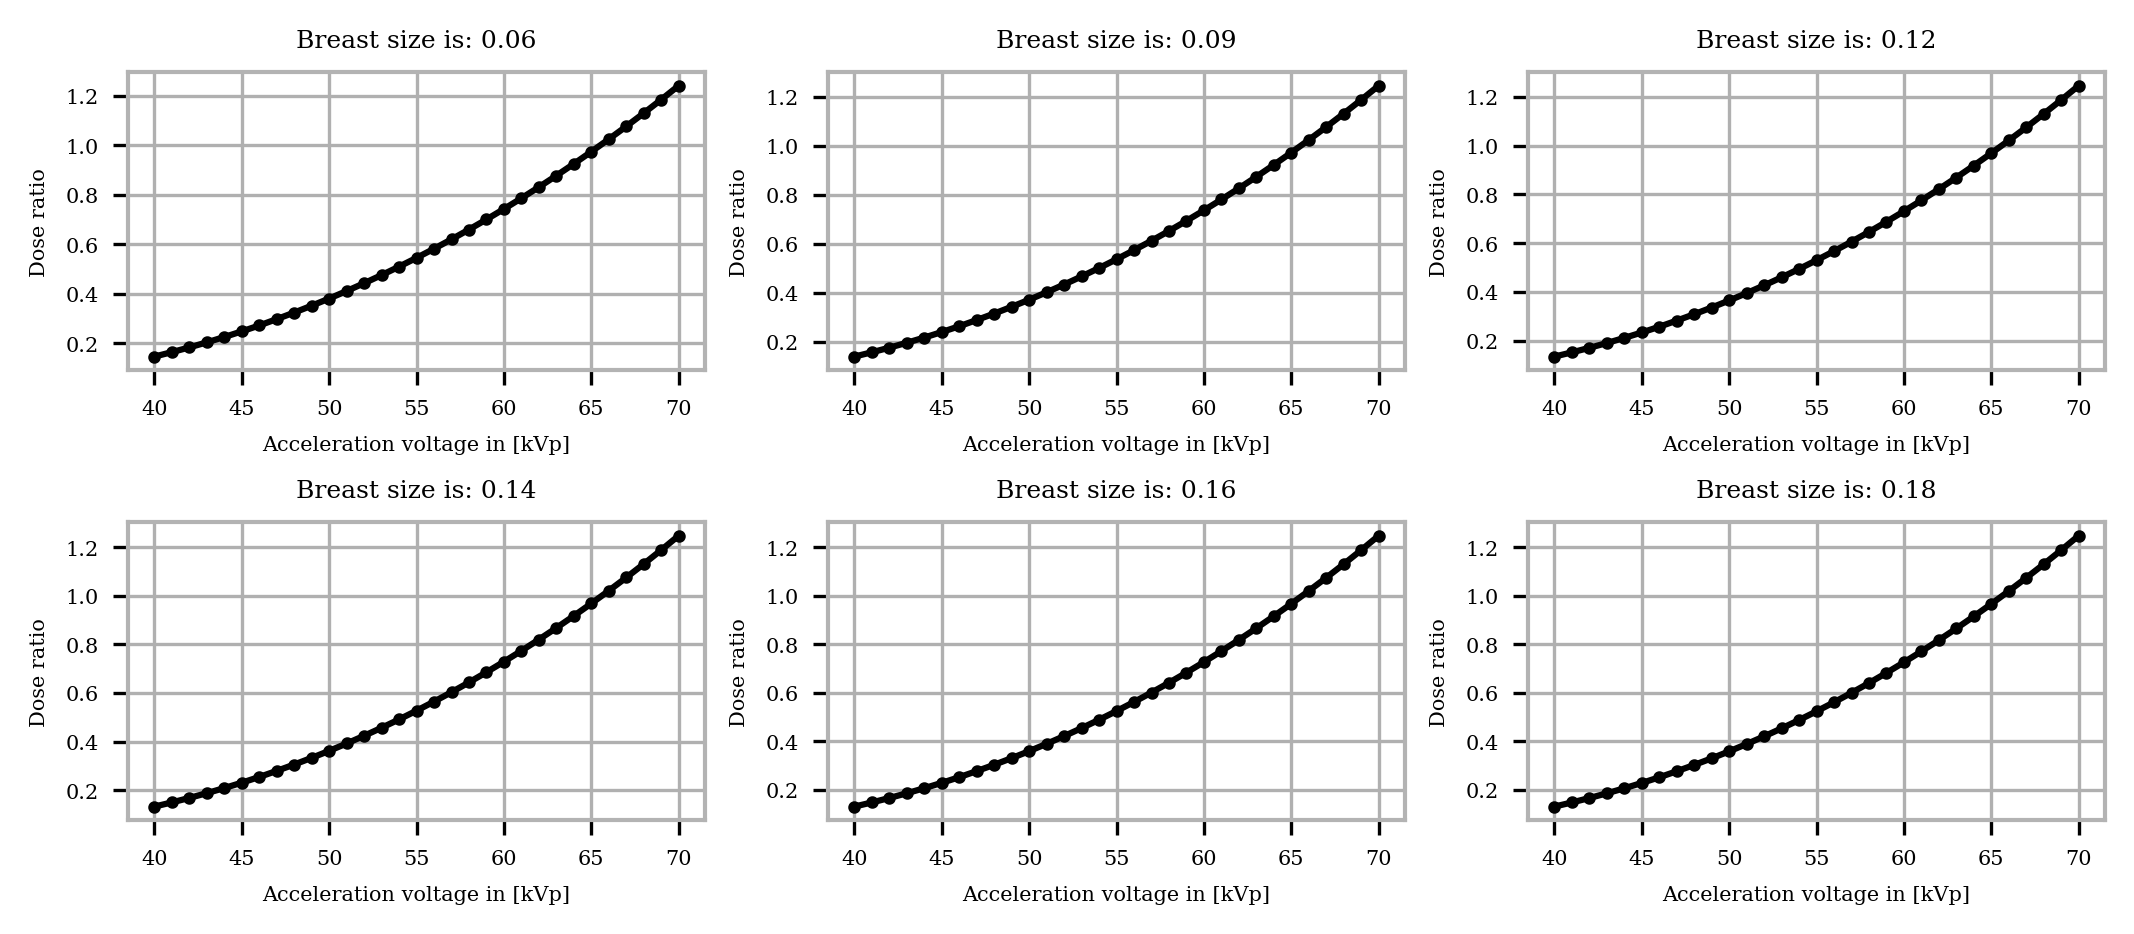

In [36]:
# Calculate counts per pixel for different breast sizes for a dose of 10mGy
nr_projections = 6000
phase_steps = 1

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(7,3))
ax = ax.ravel()
for i, bs in enumerate(breast_sizes):

    dose_size_ratio = dose_per_breast_size_static[i] / dose_per_breast_size_static[1]
    dose_ratio_per_kvp = dose_V2[bs] / dose_per_breast_size_static[i]
    ax[i].plot(tube_voltages,  dose_ratio_per_kvp)
    ax[i].set_xlabel("Acceleration voltage in [kVp]")
    ax[i].set_ylabel("Dose ratio", )
    ax[i].tick_params(axis='y')
    ax[i].set_title(f"Breast size is: {bs}")
    ax[i].grid('on')

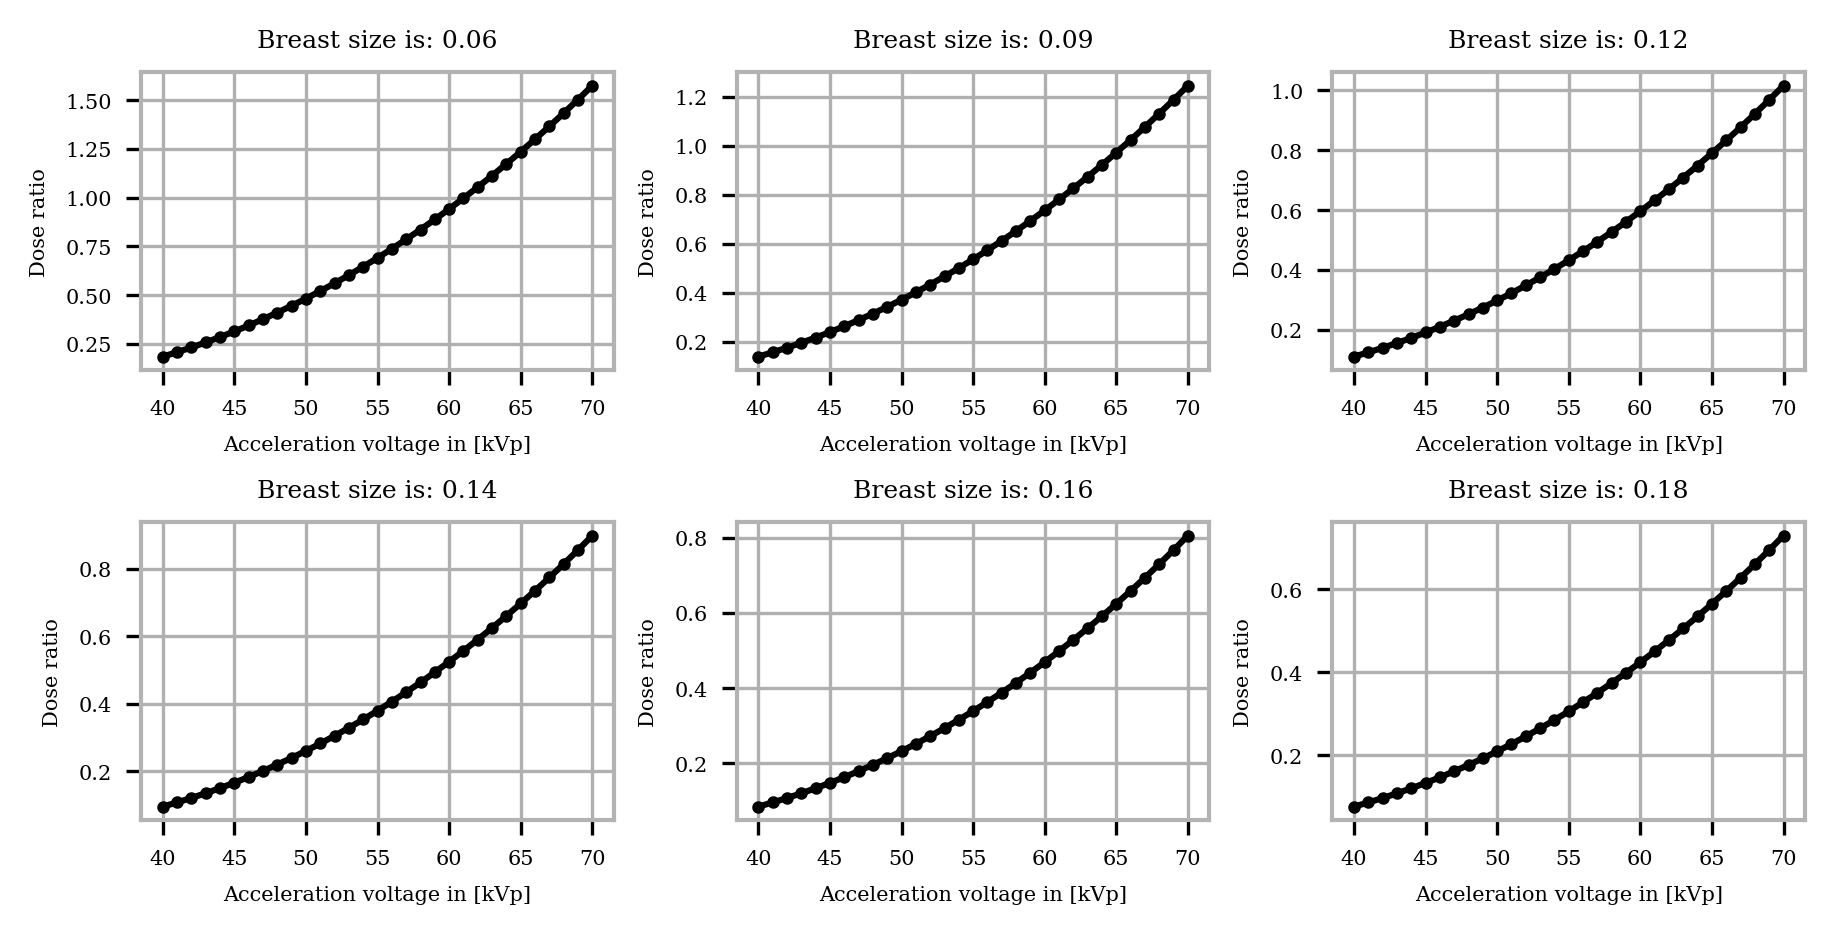

In [37]:
# Calculate counts per pixel for different breast sizes for a dose of 10mGy
nr_projections = 6000
phase_steps = 1

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(6,3))
ax = ax.ravel()
for i, bs in enumerate(breast_sizes):

    dose_size_ratio = dose_per_breast_size_static[i] / dose_per_breast_size_static[1]
    dose_ratio_per_kvp = dose_V2[bs] / dose_per_breast_size_static[i]
    ax[i].plot(tube_voltages,  dose_size_ratio * dose_ratio_per_kvp)
    ax[i].set_xlabel("Acceleration voltage in [kVp]")
    ax[i].set_ylabel("Dose ratio", )
    ax[i].tick_params(axis='y')
    ax[i].set_title(f"Breast size is: {bs}")
    ax[i].grid('on')

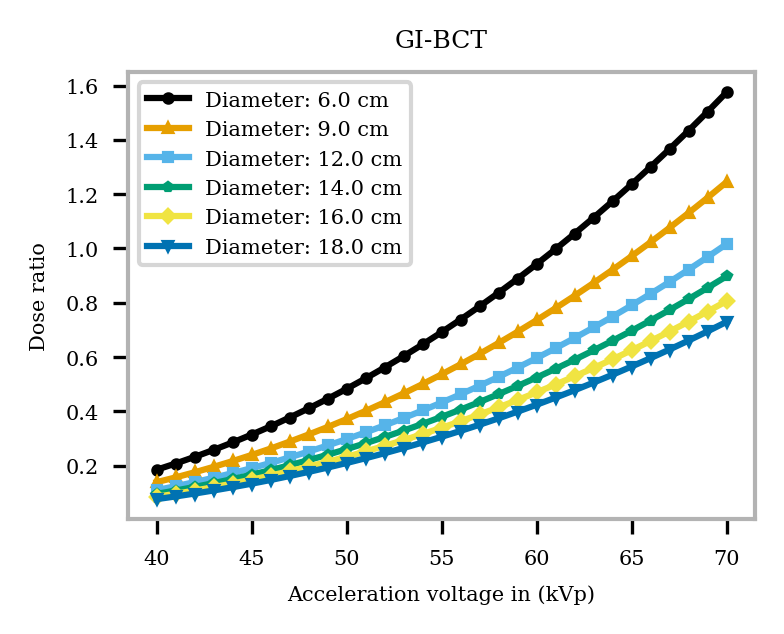

In [38]:
plt.rcParams["legend.frameon"] = True

plt.figure(figsize=(2.5,2))

for i, bs in enumerate(breast_sizes):

    dose_size_ratio = dose_per_breast_size_static[i] / dose_per_breast_size_static[1]
    dose_ratio_per_kvp = dose_V2[bs] / dose_per_breast_size_static[i]
    plt.plot(tube_voltages,  dose_size_ratio * dose_ratio_per_kvp, label = f"Diameter: {bs*1e2:.1f} cm")
plt.xlabel("Acceleration voltage in (kVp)")
plt.ylabel("Dose ratio" )
plt.tick_params(axis='y')
plt.legend()
#plt.grid('on')
plt.title('GI-BCT')
plt.rcParams["legend.frameon"] = False
plt.savefig('dose_ratio_v2_to_rawlik.png', bbox_inches = 'tight', transparent = True)

In [39]:
dose_V2[0.06] / dose_per_breast_size_static[0]

array([0.14553791, 0.16357476, 0.18278152, 0.20316761, 0.22474298,
       0.24751927, 0.27150608, 0.29722432, 0.32373875, 0.35149141,
       0.38049738, 0.41086223, 0.44248904, 0.47540308, 0.50961926,
       0.54514132, 0.58197924, 0.62015126, 0.65968612, 0.70059938,
       0.74288434, 0.78651644, 0.83150231, 0.87787665, 0.92565411,
       0.9748251 , 1.02539358, 1.07737253, 1.13078522, 1.18564539,
       1.24221843])

# Dose values for V2

In [40]:
# Get effective values
dose_ratios_V2 = {}
for i, bs in enumerate(breast_sizes):
    dose_size_ratio = dose_per_breast_size_static[i] / dose_per_breast_size_static[1]
    dose_ratio_per_kvp = dose_V2[bs] / dose_per_breast_size_static[i]

    dose_ratios_V2[bs] = dose_size_ratio * dose_ratio_per_kvp

In [41]:
dose_ratios_save_V2 = []
for bs in breast_sizes:

    dose_ratios_save_V2.append(dose_ratios_V2[bs][tube_voltages==50][0])

dose_ratios_save_V2

[0.4825954511458086,
 0.3709317366688323,
 0.2974356684283319,
 0.2605007109043642,
 0.23241791829432717,
 0.20932141777284907]

### Comparison counts at 70kVp V2 to Static at same dose

Text(1.02, 0.5, 'Dose ratio, compared to Rawlik et al.l')

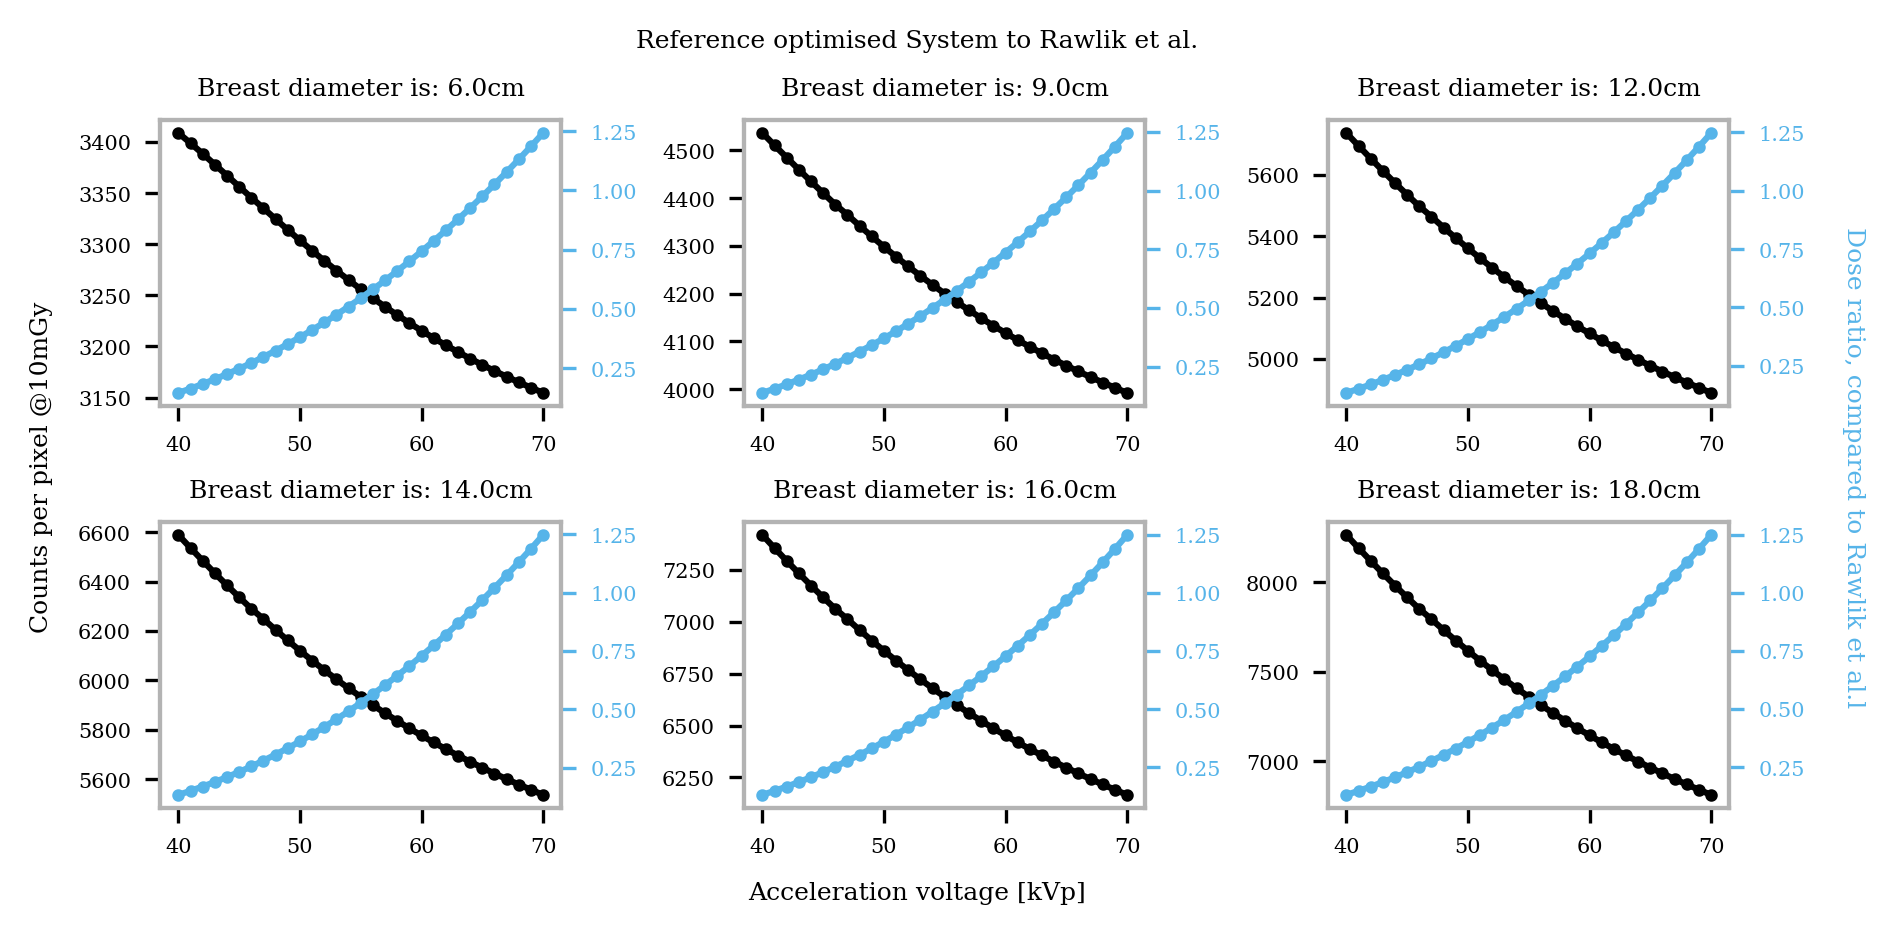

In [42]:


nr_projections = 1200
phase_steps = 1
target_dose = 10
dose_static = 22

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(6,3))
ax = ax.ravel()
for i, bs in enumerate(breast_sizes):
    dose_size_ratio = dose_per_breast_size_static[i] / dose_per_breast_size_static[1]
    dose_ratio_per_kvp = dose_V2[bs] / dose_per_breast_size_static[i]
    ax[i].plot(tube_voltages, I0_V2[bs] / (nr_projections * phase_steps) / (dose_static / target_dose) / dose_ratio_per_kvp / dose_size_ratio)
    #ax[i].set_xlabel("Acceleration voltage in [kVp]")
    #ax[i].set_ylabel("#Counts per pixel @10mGy", )
    ax[i].tick_params(axis='y')
    ax[i].set_title(f"Breast diameter is: {bs*1e2:.1f}cm")
    #ax[i].grid('on')


    ax2 = ax[i].twinx()
    color2 = "#56B4E9"
    ax2.plot(tube_voltages, dose_V2[bs] / dose_per_breast_size_static[i],  color = color2)
    #ax2.set_xlabel("Acceleration_voltage in [kVp]")
    #ax[2set_ylabel("Dose ratio, compared to Rawlik et al.", )
    ax2.tick_params(axis='y', color = color2, labelcolor = color2)
    

fig.supylabel("Counts per pixel @10mGy")
fig.supxlabel("Acceleration voltage [kVp]")
fig.suptitle('Reference optimised System to Rawlik et al.')
fig.text(1.02, 0.5, "Dose ratio, compared to Rawlik et al.l", va='center', ha='center', rotation=270, color = color2, fontsize = 6)

## Calculate now to AB-CT scanner with reference the static setup

In [43]:
pxSize_abct = 100 * 1e-4 * 2

# Geometry parameters system
l_abct = 0.3
s_abct = 0.55
z_g0_abct = 0.1

# Tube parameters
# I think this corresponds to approximately 90mGy
tube_kvp_abct = 70 # in kVp
expTime_abct = 5*60 # in seconds
current_abct =  10 # in mA

# breast size parameters
breast_sizes = [0.06, 0.09, 0.12, 0.14, 0.16, 0.18]

dose_abct = {}
I0_abct = {}
I1_abct = {}

for bs in breast_sizes:
    dose_per_kvp = []
    I0_per_kvp = []
    I1_per_kvp = []
    for kVp in tube_voltages:
        dose, I0, I1, _ = calculate_dose_and_intensity_rotation_spectrum(pxSize_abct, l_abct, s_abct, z_g0_abct, bs, kVp, expTime_static, current_static, gratings=False)
        dose_per_kvp.append(dose)
        I0_per_kvp.append(I0)
        I1_per_kvp.append(I1)    
    
    dose_per_kvp = np.asarray(dose_per_kvp)
    I0_per_kvp = np.asarray(I0_per_kvp)
    I1_per_kvp = np.asarray(I1_per_kvp)

    dose_abct[bs] = dose_per_kvp
    I0_abct[bs] = I0_per_kvp
    I1_abct[bs] = I1_per_kvp


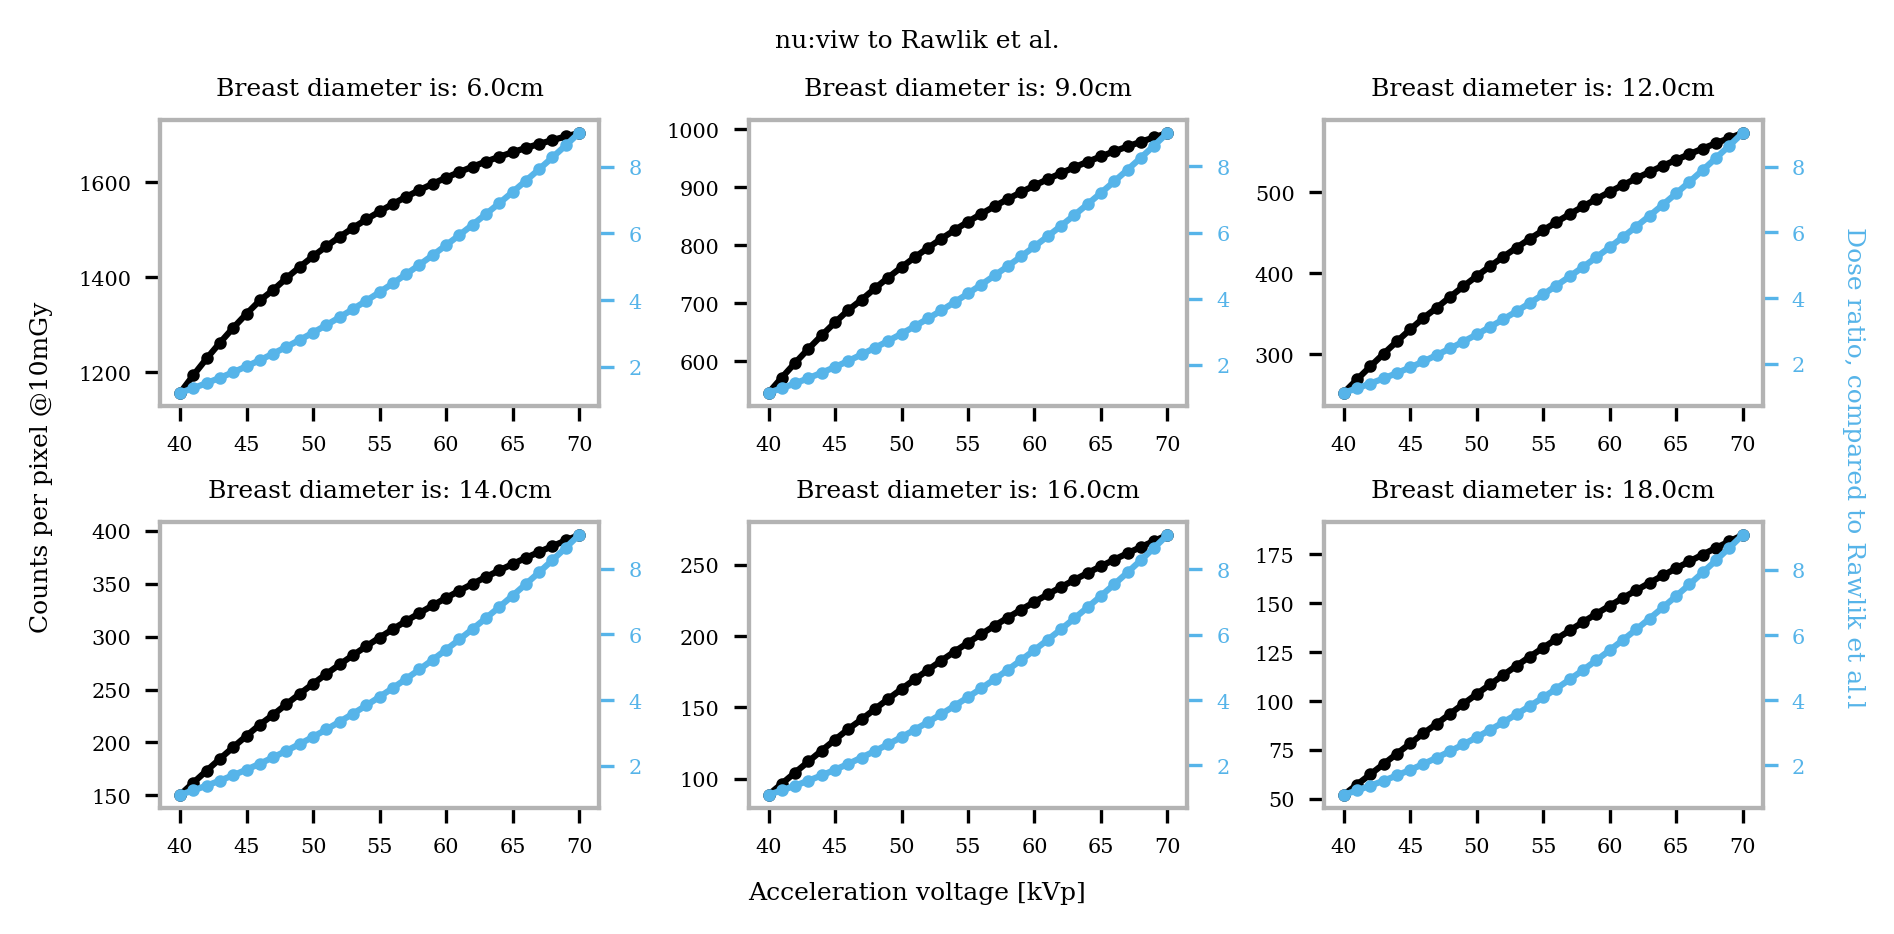

In [44]:


nr_projections = 1200
phase_steps = 1
target_dose = 10
dose_static = 22

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(6,3))
ax = ax.ravel()
for i, bs in enumerate(breast_sizes):
    dose_size_ratio = dose_per_breast_size_static[i] / dose_per_breast_size_static[1]
    dose_ratio_per_kvp = dose_abct[bs] / dose_per_breast_size_static[i]
    ax[i].plot(tube_voltages, I1_abct[bs] / (nr_projections * phase_steps) / (dose_static / target_dose) / dose_ratio_per_kvp / dose_size_ratio)
    #ax[i].set_xlabel("Acceleration voltage in [kVp]")
    #ax[i].set_ylabel("#Counts per pixel @10mGy", )
    ax[i].tick_params(axis='y')
    ax[i].set_title(f"Breast diameter is: {bs*1e2:.1f}cm")
    #ax[i].grid('on')


    ax2 = ax[i].twinx()
    color2 = "#56B4E9"
    ax2.plot(tube_voltages, dose_abct[bs] / dose_per_breast_size_static[i],  color = color2)
    #ax2.set_xlabel("Acceleration_voltage in [kVp]")
    #ax[2set_ylabel("Dose ratio, compared to Rawlik et al.", )
    ax2.tick_params(axis='y', color = color2, labelcolor = color2)
    

fig.supylabel("Counts per pixel @10mGy")
fig.supxlabel("Acceleration voltage [kVp]")
fig.suptitle('nu:viw to Rawlik et al.')
fig.text(1.02, 0.5, "Dose ratio, compared to Rawlik et al.l", va='center', ha='center', rotation=270, color = color2, fontsize = 6)

plt.savefig('counts_dose_nuview.png', bbox_inches ='tight')
#plt.supylabel("Counts per pixel @10mGy")
#plt.suptitle(f"Counts per pixel for {nr_projections} projections, {pxSize_V2*1e4}µm pixel size and 10mGy")

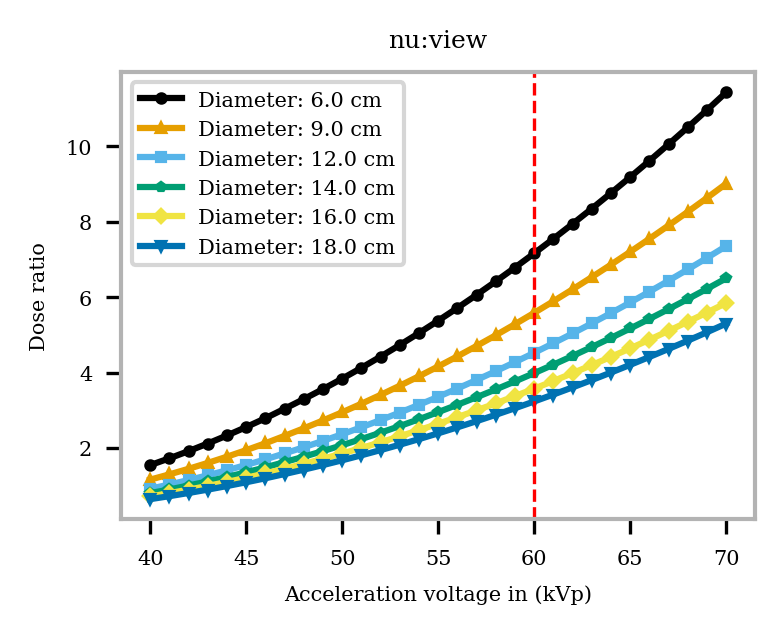

In [45]:
plt.rcParams["legend.frameon"] = True

plt.figure(figsize=(2.5,2))

for i, bs in enumerate(breast_sizes):

    dose_size_ratio = dose_per_breast_size_static[i] / dose_per_breast_size_static[1]
    dose_ratio_per_kvp = dose_abct[bs] / dose_per_breast_size_static[i]
    plt.plot(tube_voltages,  dose_size_ratio * dose_ratio_per_kvp, label = f"Diameter: {bs*1e2:.1f} cm")
plt.xlabel("Acceleration voltage in (kVp)")
plt.ylabel("Dose ratio" )
plt.tick_params(axis='y')
plt.legend()
#plt.grid('on')
plt.axvline(60, linestyle='--', color = 'r', lw = 0.8)
plt.rcParams["legend.frameon"] = False
plt.title("nu:view")
plt.savefig('dose_ratio_nuview_to_rawlik.png', bbox_inches = 'tight', transparent = True)

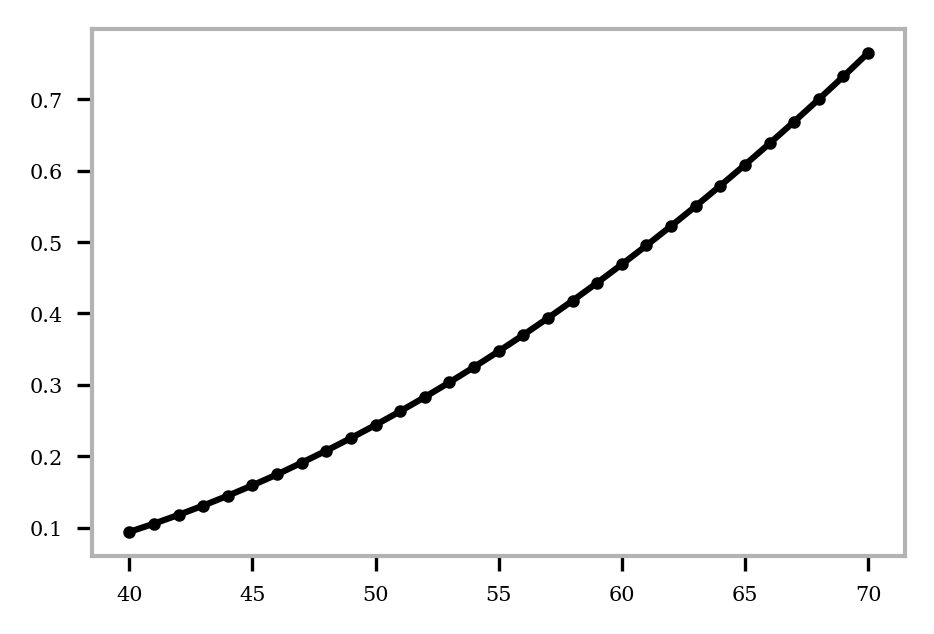

In [46]:
plt.plot(tube_voltages,dose_abct[0.14])

In [47]:
# Get effective values
dose_ratios_abct = {}
for i, bs in enumerate(breast_sizes):
    dose_size_ratio = dose_per_breast_size_static[i] / dose_per_breast_size_static[1]
    dose_ratio_per_kvp = dose_abct[bs] / dose_per_breast_size_static[i]

    dose_ratios_abct[bs] = dose_size_ratio * dose_ratio_per_kvp

In [48]:
dose_ratios_save_nuview = []
for bs in breast_sizes:

    dose_ratios_save_nuview.append(dose_ratios_abct[bs][tube_voltages==60][0])

dose_ratios_save_nuview

[7.1630086369055315,
 5.582669223733254,
 4.523026496398427,
 3.9833858691217747,
 3.571838356310536,
 3.2317085125456058]